In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.analysis.state_space import StateSpaceAnalysisSpec

In [5]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [6]:
# use a word-level equivalence dataset regardless of model, so that we can look up cohort facts
equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_6_1.pkl"
timit_corpus_path = "data/timit_syllables"

state_space_spec_path = "out/state_space_specs/all_words.pkl"

plot_models = ["w2v2_6_8"]
plot_equivalences = ["random", "phoneme", "syllable", "word"]

In [7]:
# Get distribution of frame spans for words and phonemes according to state trajectory spec
with open("out/state_space_specs/all_words.pkl", "rb") as f:
    word_trajectory_spec = pickle.load(f)
with open("out/state_space_specs/all_phonemes_by_identity.pkl", "rb") as f:
    phoneme_trajectory_spec = pickle.load(f)
with open("out/state_space_specs/all_syllables.pkl", "rb") as f:
    syllable_trajectory_spec = pickle.load(f)

In [8]:
word_frame_durations = pd.Series([end - start for frame_spans in word_trajectory_spec.target_frame_spans for start, end in frame_spans])
phoneme_frame_durations = pd.Series([end - start for frame_spans in phoneme_trajectory_spec.target_frame_spans for start, end in frame_spans])
syllable_frame_durations = pd.Series([end - start for frame_spans in syllable_trajectory_spec.target_frame_spans for start, end in frame_spans])

In [9]:
lengths_df = pd.concat([word_frame_durations, phoneme_frame_durations, syllable_frame_durations],
                       keys=["word", "phoneme", "syllable"], names=["unit"]).rename("length").reset_index()
lengths_df["duration"] = lengths_df["length"] / 20

In [10]:
lengths_df

unit  level_1  length  duration
0           word        0       8      0.40
1           word        1       7      0.35
2           word        2      10      0.50
3           word        3      10      0.50
4           word        4      13      0.65
...          ...      ...     ...       ...
250081  syllable    59459      24      1.20
250082  syllable    59460      35      1.75
250083  syllable    59461      15      0.75
250084  syllable    59462      19      0.95
250085  syllable    59463      20      1.00

[250086 rows x 4 columns]

phoneme 0.2
syllable 0.45
word 0.7


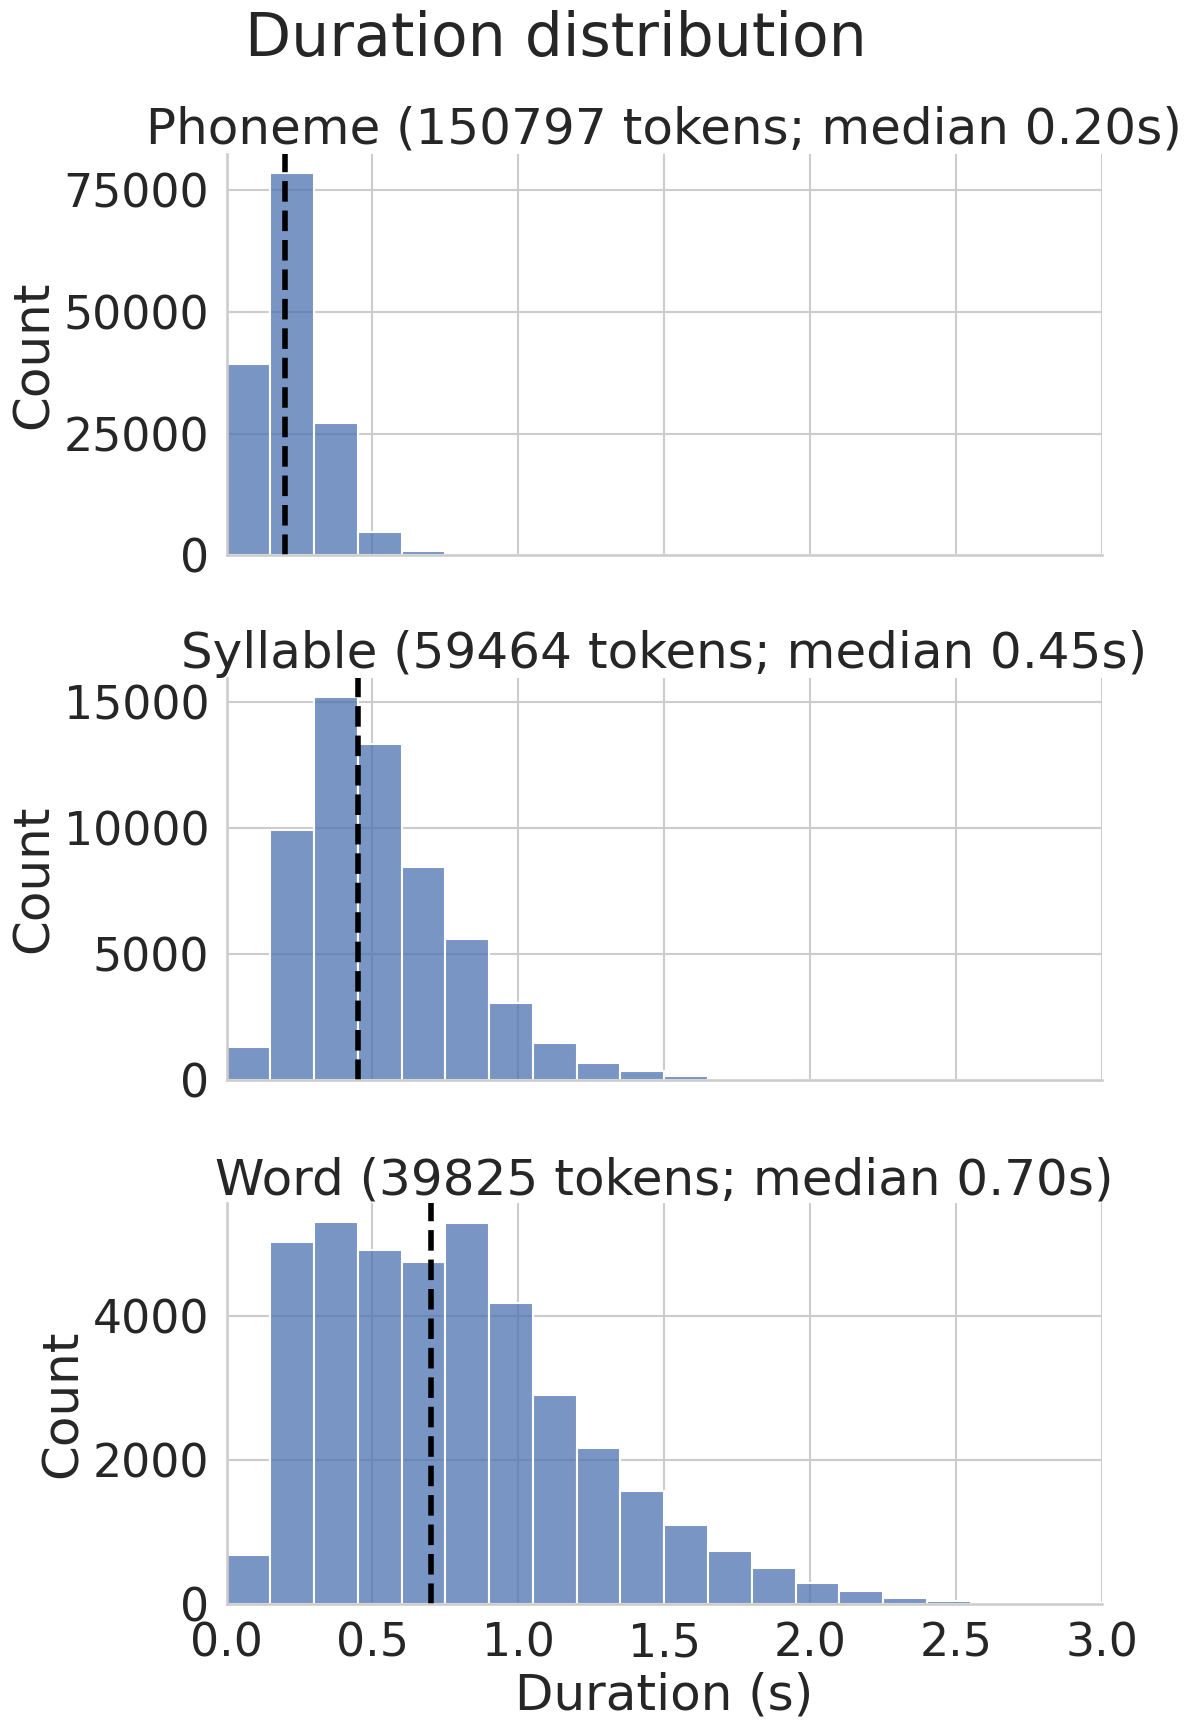

In [11]:
row_order = ["phoneme", "syllable", "word"]
g = sns.displot(
    lengths_df.reset_index(), x="duration", row="unit", row_order=row_order,
    binwidth=3 / 20, height=6, aspect=2, facet_kws=dict(sharey=False),
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Duration distribution")

for ax, unit in zip(g.axes.flat, row_order):
    median_length = lengths_df[lengths_df["unit"] == unit]["duration"].median()
    ax.set_title(f"{unit.capitalize()} ({len(lengths_df[lengths_df['unit'] == unit])} tokens; median {median_length:.2f}s)")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Count")
    ax.set_xlim((0, 3))

    print(unit, median_length)
    ax.axvline(median_length, color="black", linestyle="--", linewidth=4)

In [12]:
phoneme_in_word_df = word_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_word_df

/tmp/ipykernel_4136655/54656410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
/tmp/ipykernel_4136655/54656410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)


description  onset_frame_idx  offset_frame_idx  item_idx  \
label instance_idx                                                            
'em   0                     AH           129121            129123       852   
      0                      M           129123            129125       852   
      1                     AH           204156            204159      1352   
      1                      M           204159            204162      1352   
      2                     AH           204247            204251      1352   
...                        ...              ...               ...       ...   
zoos  5                     UW           514588            514603      3338   
      5                      S           514603            514617      3338   
      6                      Z           596767            596772      3877   
      6                     UW           596772            596786      3877   
      6                      Z           596786            596791      3877   

                    idx_in_level  rev_idx_in_level  
label instance_idx                                  
'em   0                        0                 1  
      0                        1                 0  
      1                        0                 1  
      1                        1                 0  
      2                        0                 1  
...                          ...               ...  
zoos  5                        1                 1  
      5                        2                 0  
      6                        0                 2  
      6                        1                 1  
      6                        2                 0  

[150797 rows x 6 columns]

In [13]:
phoneme_in_syllable_df = syllable_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_syllable_df["idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_syllable_df["rev_idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_syllable_df

description  onset_frame_idx  offset_frame_idx  \
label       instance_idx                                                  
(AA,)       0                     AA              839               845   
            1                     AA            13234             13242   
            2                     AA            13271             13279   
            3                     AA            13509             13514   
            4                     AA            16014             16020   
...                              ...              ...               ...   
(ZH, UW, L) 0                     UW           192168            192172   
            0                      L           192172            192175   
(ZH, UW, Z) 0                     ZH           614741            614745   
            0                     UW           614745            614750   
            0                      Z           614750            614754   

                          item_idx  idx_in_level  rev_idx_in_level  
label       instance_idx                                            
(AA,)       0                    6             0                 0  
            1                   85             0                 0  
            2                   85             0                 0  
            3                   86             0                 0  
            4                  104             0                 0  
...                            ...           ...               ...  
(ZH, UW, L) 0                 1275             1                 1  
            0                 1275             2                 0  
(ZH, UW, Z) 0                 3994             0                 2  
            0                 3994             1                 1  
            0                 3994             2                 0  

[150797 rows x 6 columns]

In [33]:
phoneme_in_syllable_df[phoneme_in_syllable_df.idx_in_level == 6]

description  onset_frame_idx  \
label                      instance_idx                                
(D, R, EH, N, T, CH, T)    0                      T           140081   
                           1                      T           290305   
                           2                      T           635035   
(F, R, IY, K, W, N, T)     0                      T           610328   
(S, K, W, EH, L, T, CH, T) 0                     CH           417638   
(S, P, L, ER, D, JH, D)    0                      D           190823   
                           1                      D           303664   

                                         offset_frame_idx  item_idx  \
label                      instance_idx                               
(D, R, EH, N, T, CH, T)    0                       140083       929   
                           1                       290309      1929   
                           2                       635037      4129   
(F, R, IY, K, W, N, T)     0                       610330      3966   
(S, K, W, EH, L, T, CH, T) 0                       417643      2733   
(S, P, L, ER, D, JH, D)    0                       190826      1267   
                           1                       303667      2017   

                                         idx_in_level  rev_idx_in_level  \
label                      instance_idx                                   
(D, R, EH, N, T, CH, T)    0                        6                 0   
                           1                        6                 0   
                           2                        6                 0   
(F, R, IY, K, W, N, T)     0                        6                 0   
(S, K, W, EH, L, T, CH, T) 0                        6                 1   
(S, P, L, ER, D, JH, D)    0                        6                 0   
                           1                        6                 0   

                                         relative_onset  \
label                      instance_idx                   
(D, R, EH, N, T, CH, T)    0                         15   
                           1                         26   
                           2                         15   
(F, R, IY, K, W, N, T)     0                         14   
(S, K, W, EH, L, T, CH, T) 0                         29   
(S, P, L, ER, D, JH, D)    0                         31   
                           1                         31   

                                         reverse_relative_onset  
label                      instance_idx                          
(D, R, EH, N, T, CH, T)    0                                 -2  
                           1                                 -4  
                           2                                 -2  
(F, R, IY, K, W, N, T)     0                                 -2  
(S, K, W, EH, L, T, CH, T) 0                                 -9  
(S, P, L, ER, D, JH, D)    0                                 -3  
                           1                                 -3

In [14]:
# Phoneme stats

# mean onset of each phoneme relative to syllable start
phoneme_in_syllable_df["relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_syllable_mean_onsets = phoneme_in_syllable_df.groupby("idx_in_level").relative_onset.mean() / 20
phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_word_mean_onsets = phoneme_in_word_df.groupby("idx_in_level").relative_onset.mean() / 20

# mean onset of each phoneme indexed from end, relative to end
phoneme_in_syllable_df["reverse_relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_syllable_reverse_mean_onsets = -phoneme_in_syllable_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_word_reverse_mean_onsets = -phoneme_in_word_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_reverse_mean_onsets

/tmp/ipykernel_4136655/3890120054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
/tmp/ipykernel_4136655/3890120054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()


rev_idx_in_level
0     0.197739
1     0.398935
2     0.626231
3     0.794941
4     0.965803
5     1.132009
6     1.283628
7     1.428296
8     1.587408
9     1.703520
10    1.848629
11    2.029046
12    2.175843
13    2.331915
14    2.630556
15    3.550000
Name: reverse_relative_onset, dtype: float64

In [15]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [16]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

# Coherence analyses

In [17]:
def truncate_contrasts(distance_df, min_contrast_instances=50) -> pd.DataFrame:
    # We want to make comparisons between contrasts only when we have enough data
    # between individual units in the contrast to have a meaningful mean.
    # e.g. if a "within" contrast at frame 5 only has 2 instances, it's not so informative to compare this mean to the "between" contrast at frame 5.

    # Find the maximum frame at which, for all contrasts, we have at least `min_contrast_instances` instances
    # underlying each contrast value.
    max_contrast_frame = distance_df.groupby(["model", "equivalence", "frame"]) \
        .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
        .groupby(["model", "equivalence"]).idxmax().str[-1].min()
    
    return distance_df[distance_df.frame < max_contrast_frame]

In [18]:
def load_grouped_distances(glob, plot_models, plot_equivalences, min_contrast_instances=50):
    syll_onset_paths = list(Path("outputs/notebooks").glob(glob))

    syll_onset_keys, syll_onset_dfs = [], []
    for path in syll_onset_paths:
        syll_onset_dfs.append(pd.read_csv(path))

        model_name = path.parents[2].name
        if model_name.startswith("random"):
            model_name = re.sub(r"random[^_]*_", "", model_name)
        syll_onset_keys.append((model_name, path.parents[1].name))

    syll_onset_distance_df = pd.concat(syll_onset_dfs, names=["model", "equivalence"], keys=syll_onset_keys)
    syll_onset_distance_df = syll_onset_distance_df.loc[
        syll_onset_distance_df.index.get_level_values("equivalence").isin(plot_equivalences) &
        syll_onset_distance_df.index.get_level_values("model").isin(plot_models)]
    syll_onset_distance_df = truncate_contrasts(syll_onset_distance_df, min_contrast_instances=min_contrast_instances)

    return syll_onset_distance_df

In [19]:
def plot_coherence(coherence_df, unit, alignment="onset",
                   plot_phonemes=None, sharex=True, legend=False, plot_kwargs=None, **kwargs):
    coherence_df = coherence_df.reset_index()
    coherence_df["equivalence"] = coherence_df.equivalence.str.capitalize()

    default_kwargs = dict(col_wrap=2)
    kwargs = {**default_kwargs, **kwargs}
    g = sns.FacetGrid(data=coherence_df, col="equivalence", col_order=[e.capitalize() for e in plot_equivalences],
                      sharex=sharex, sharey=True, height=8, aspect=2, **kwargs)
    g.map(sns.lineplot, "time", "distance", "type", **(plot_kwargs or {}))

    if legend:
        g.add_legend()
    g.set_titles(template="{col_name}")

    for ax in g.axes.flat:
        ax.grid(False)
        ax.set_ylim((-0.2, 1.2))
        ax.axhline(0, color="gray", linestyle="--", alpha=0.8)
        ax.axhline(1, color="gray", linestyle="--", alpha=0.8)
        ax.set_ylabel("Cosine distance")

        if alignment == "onset":
            ax.set_xlim((-.065, ax.get_xlim()[1]))
            ax.set_xlabel(f"Time since {unit} onset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(0, (ymax - ymin) / 3, f"{unit.capitalize()} onset", color="gray",
                    rotation=90, ha="right", va="center",
                    fontsize="large", fontweight="bold")
        elif alignment == "offset":
            ax.set_xlabel(f"Time until {unit} offset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(-0.05, (ymax - ymin) / 3, f"{unit.capitalize()} offset", color="gray",
                    rotation=90, ha="left", va="center",
                    fontsize="large", fontweight="bold")

        if plot_phonemes is not None:
            xmin, xmax = ax.get_xlim()
            for phoneme_onset in plot_phonemes:
                if phoneme_onset < xmax:
                    ax.axvline(phoneme_onset, color="salmon", linestyle="--", alpha=0.5)

    if alignment == "offset":
        if sharex:
            # will apply to all
            g.axes.flat[0].invert_xaxis()
        else:
            for ax in g.axes.flat:
                ax.invert_xaxis()

    return g

## Phoneme-level coherence

In [85]:
phoneme_distance_by_position_df = load_grouped_distances(
    "**/phoneme_coherence_by_position/distances.csv", plot_models, plot_equivalences, min_contrast_instances=10)
phoneme_distance_by_position_df["time"] = phoneme_distance_by_position_df["frame"] / 20

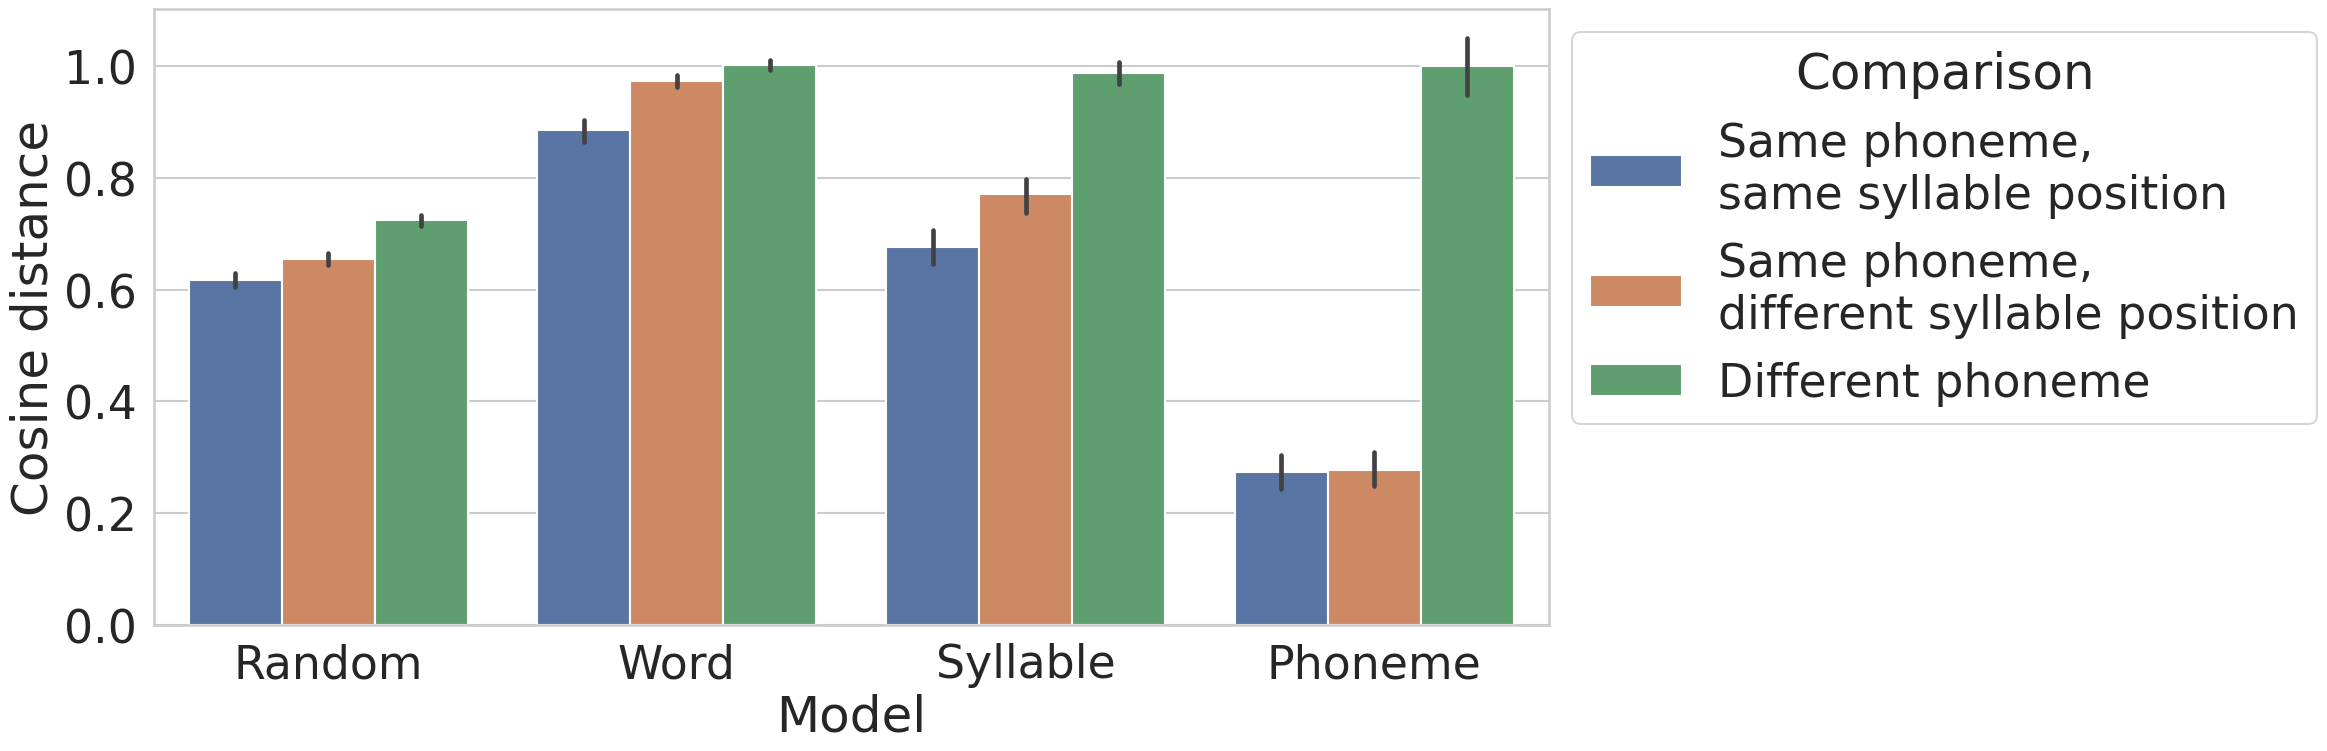

In [103]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_position_df.reset_index()
phoneme_plot_data["equivalence"] = phoneme_plot_data["equivalence"].str.capitalize()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Same phoneme,\nsame syllable position",
     "different_position": "Same phoneme,\ndifferent syllable position",
     "between": "Different phoneme"}
)
sns.barplot(data=phoneme_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### By phoneme category

In [105]:
phoneme_distance_by_cv_df = load_grouped_distances(
    "**/phoneme_coherence/grouped_distances.csv", plot_models, plot_equivalences)
phoneme_distance_by_cv_df["time"] = phoneme_distance_by_cv_df["frame"] / 20

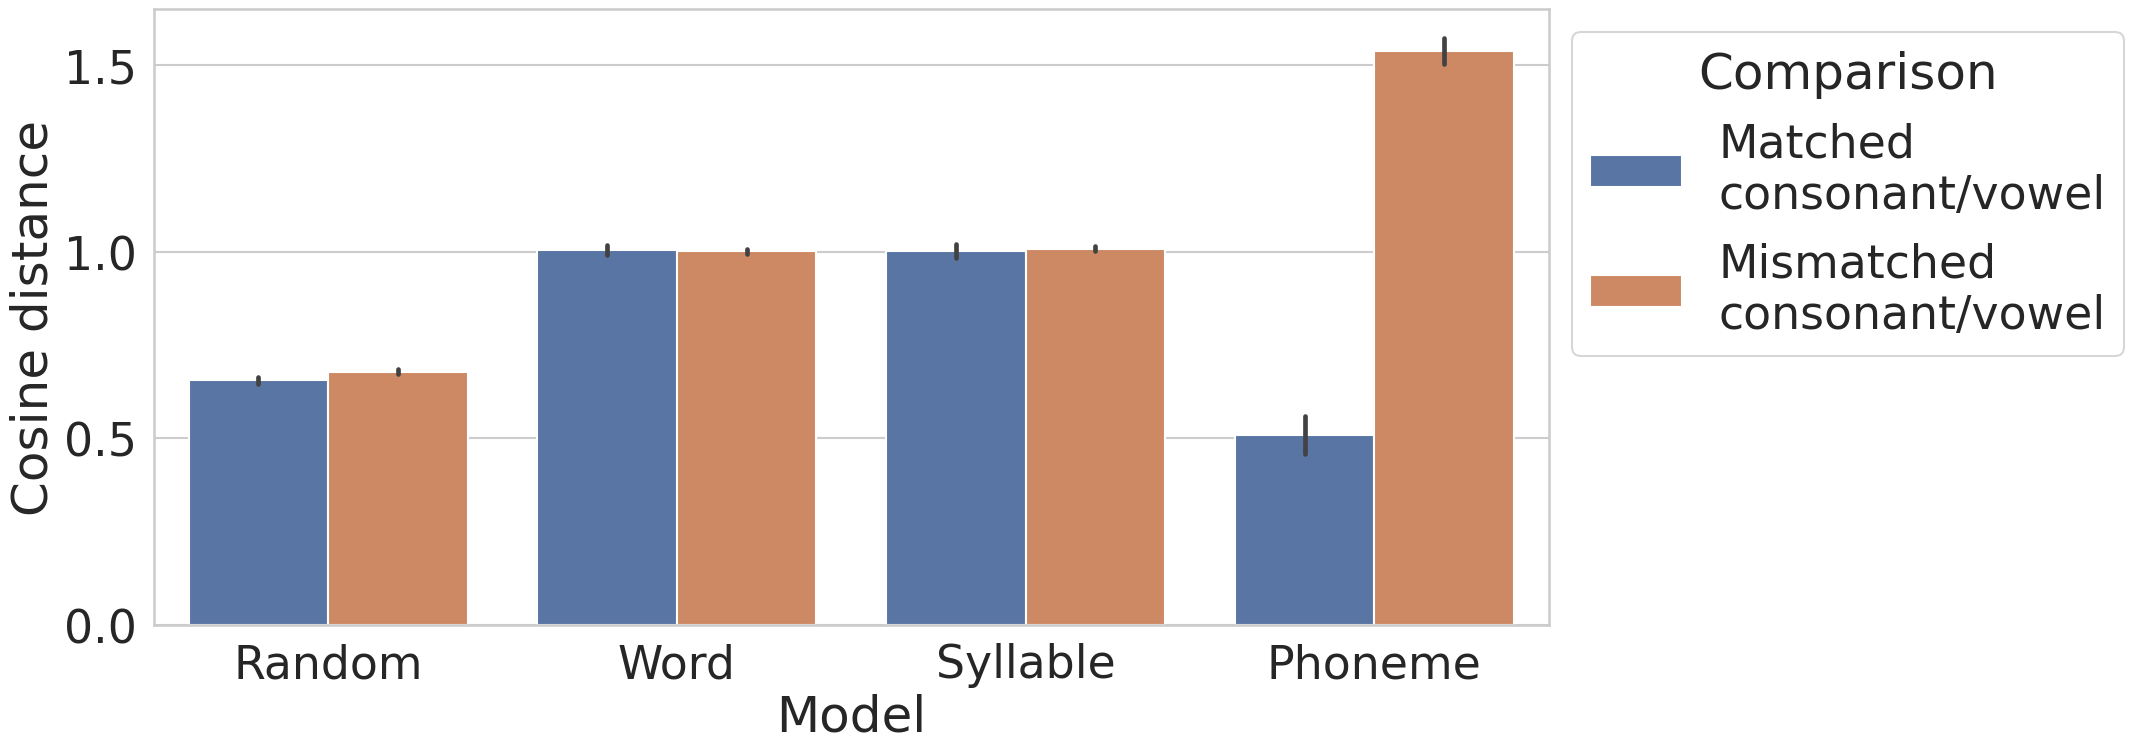

In [108]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_cv_df.reset_index()
phoneme_plot_data["equivalence"] = phoneme_plot_data["equivalence"].str.capitalize()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Matched\nconsonant/vowel",
     "between": "Mismatched\nconsonant/vowel"}
)
sns.barplot(data=phoneme_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

## Syllable-level coherence

In [155]:
syll_distance_by_position_df = load_grouped_distances("**/syllable_coherence_by_position/distances.csv", plot_models, plot_equivalences, min_contrast_instances=100)

In [164]:
syll_distance_by_position_df["syllable_position"] = syll_distance_by_position_df.syllable.str.split(" ").str[-1].astype(int)

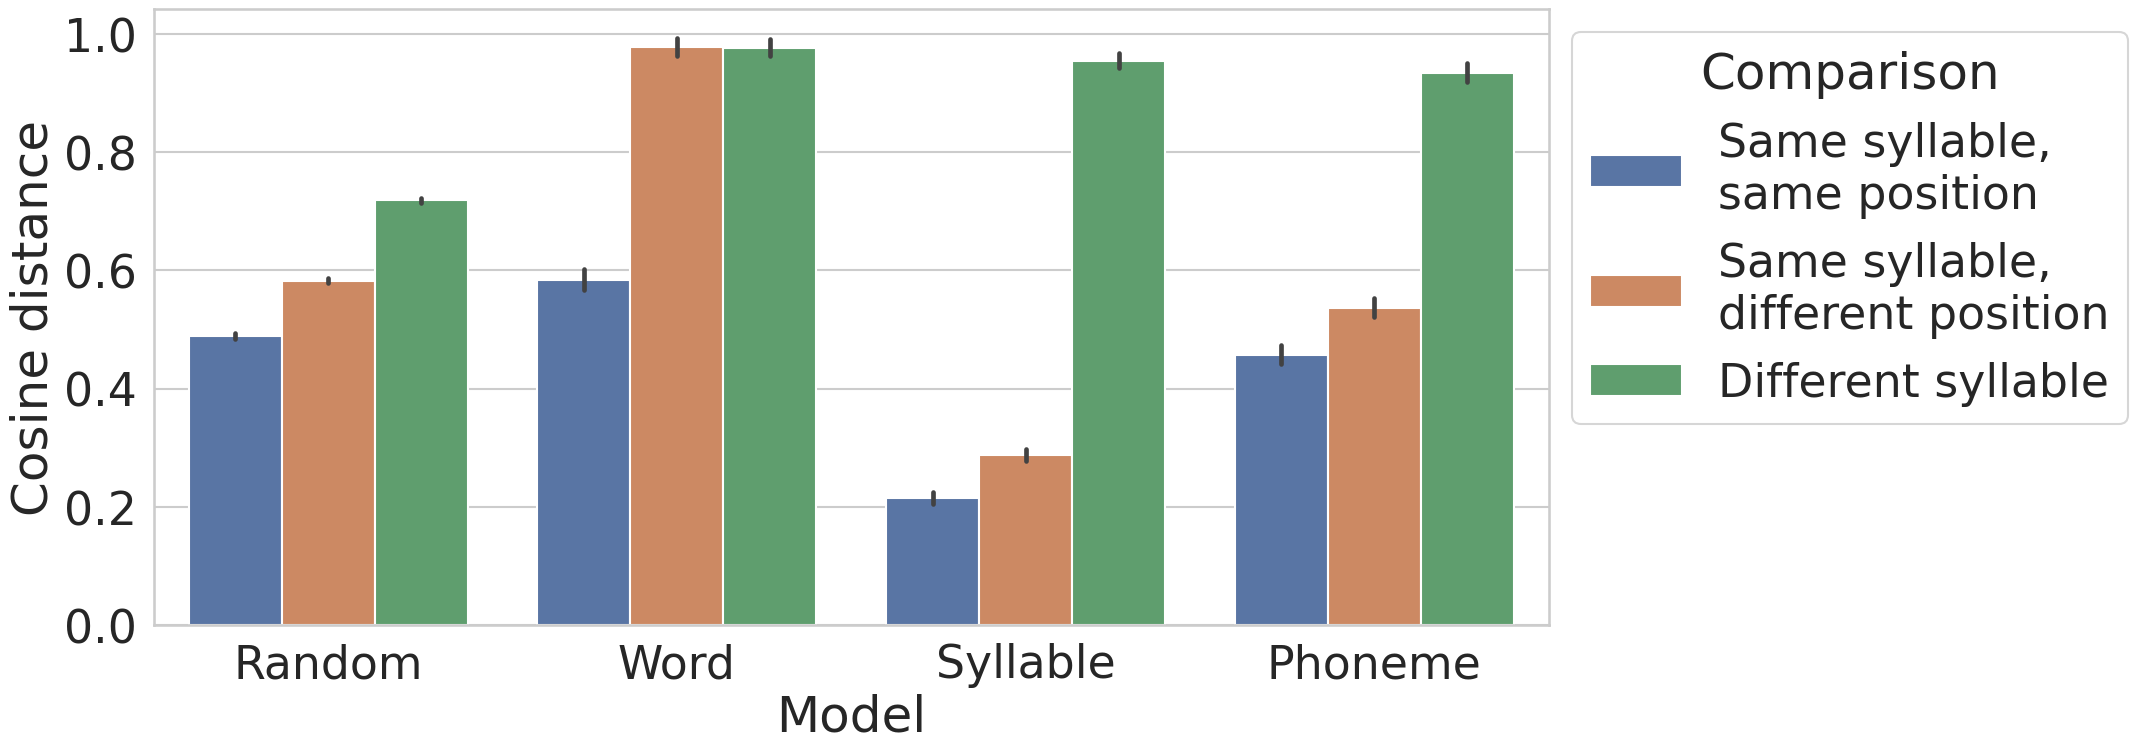

In [167]:
f, ax = plt.subplots(figsize=(18, 8))
syllable_plot_data = syll_distance_by_position_df.reset_index()
syllable_plot_data["equivalence"] = syllable_plot_data["equivalence"].str.capitalize()
syllable_plot_data["type"] = syllable_plot_data["type"].map(
    {"within": "Same syllable,\nsame position",
     "different_position": "Same syllable,\ndifferent position",
     "between": "Different syllable"}
)
sns.barplot(data=syllable_plot_data,#[syllable_plot_data.syllable_position],
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### Grouped by onset

In [49]:
syll_onset_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset.csv", plot_models, plot_equivalences)
syll_onset_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset_aligned_offset.csv", plot_models, plot_equivalences)

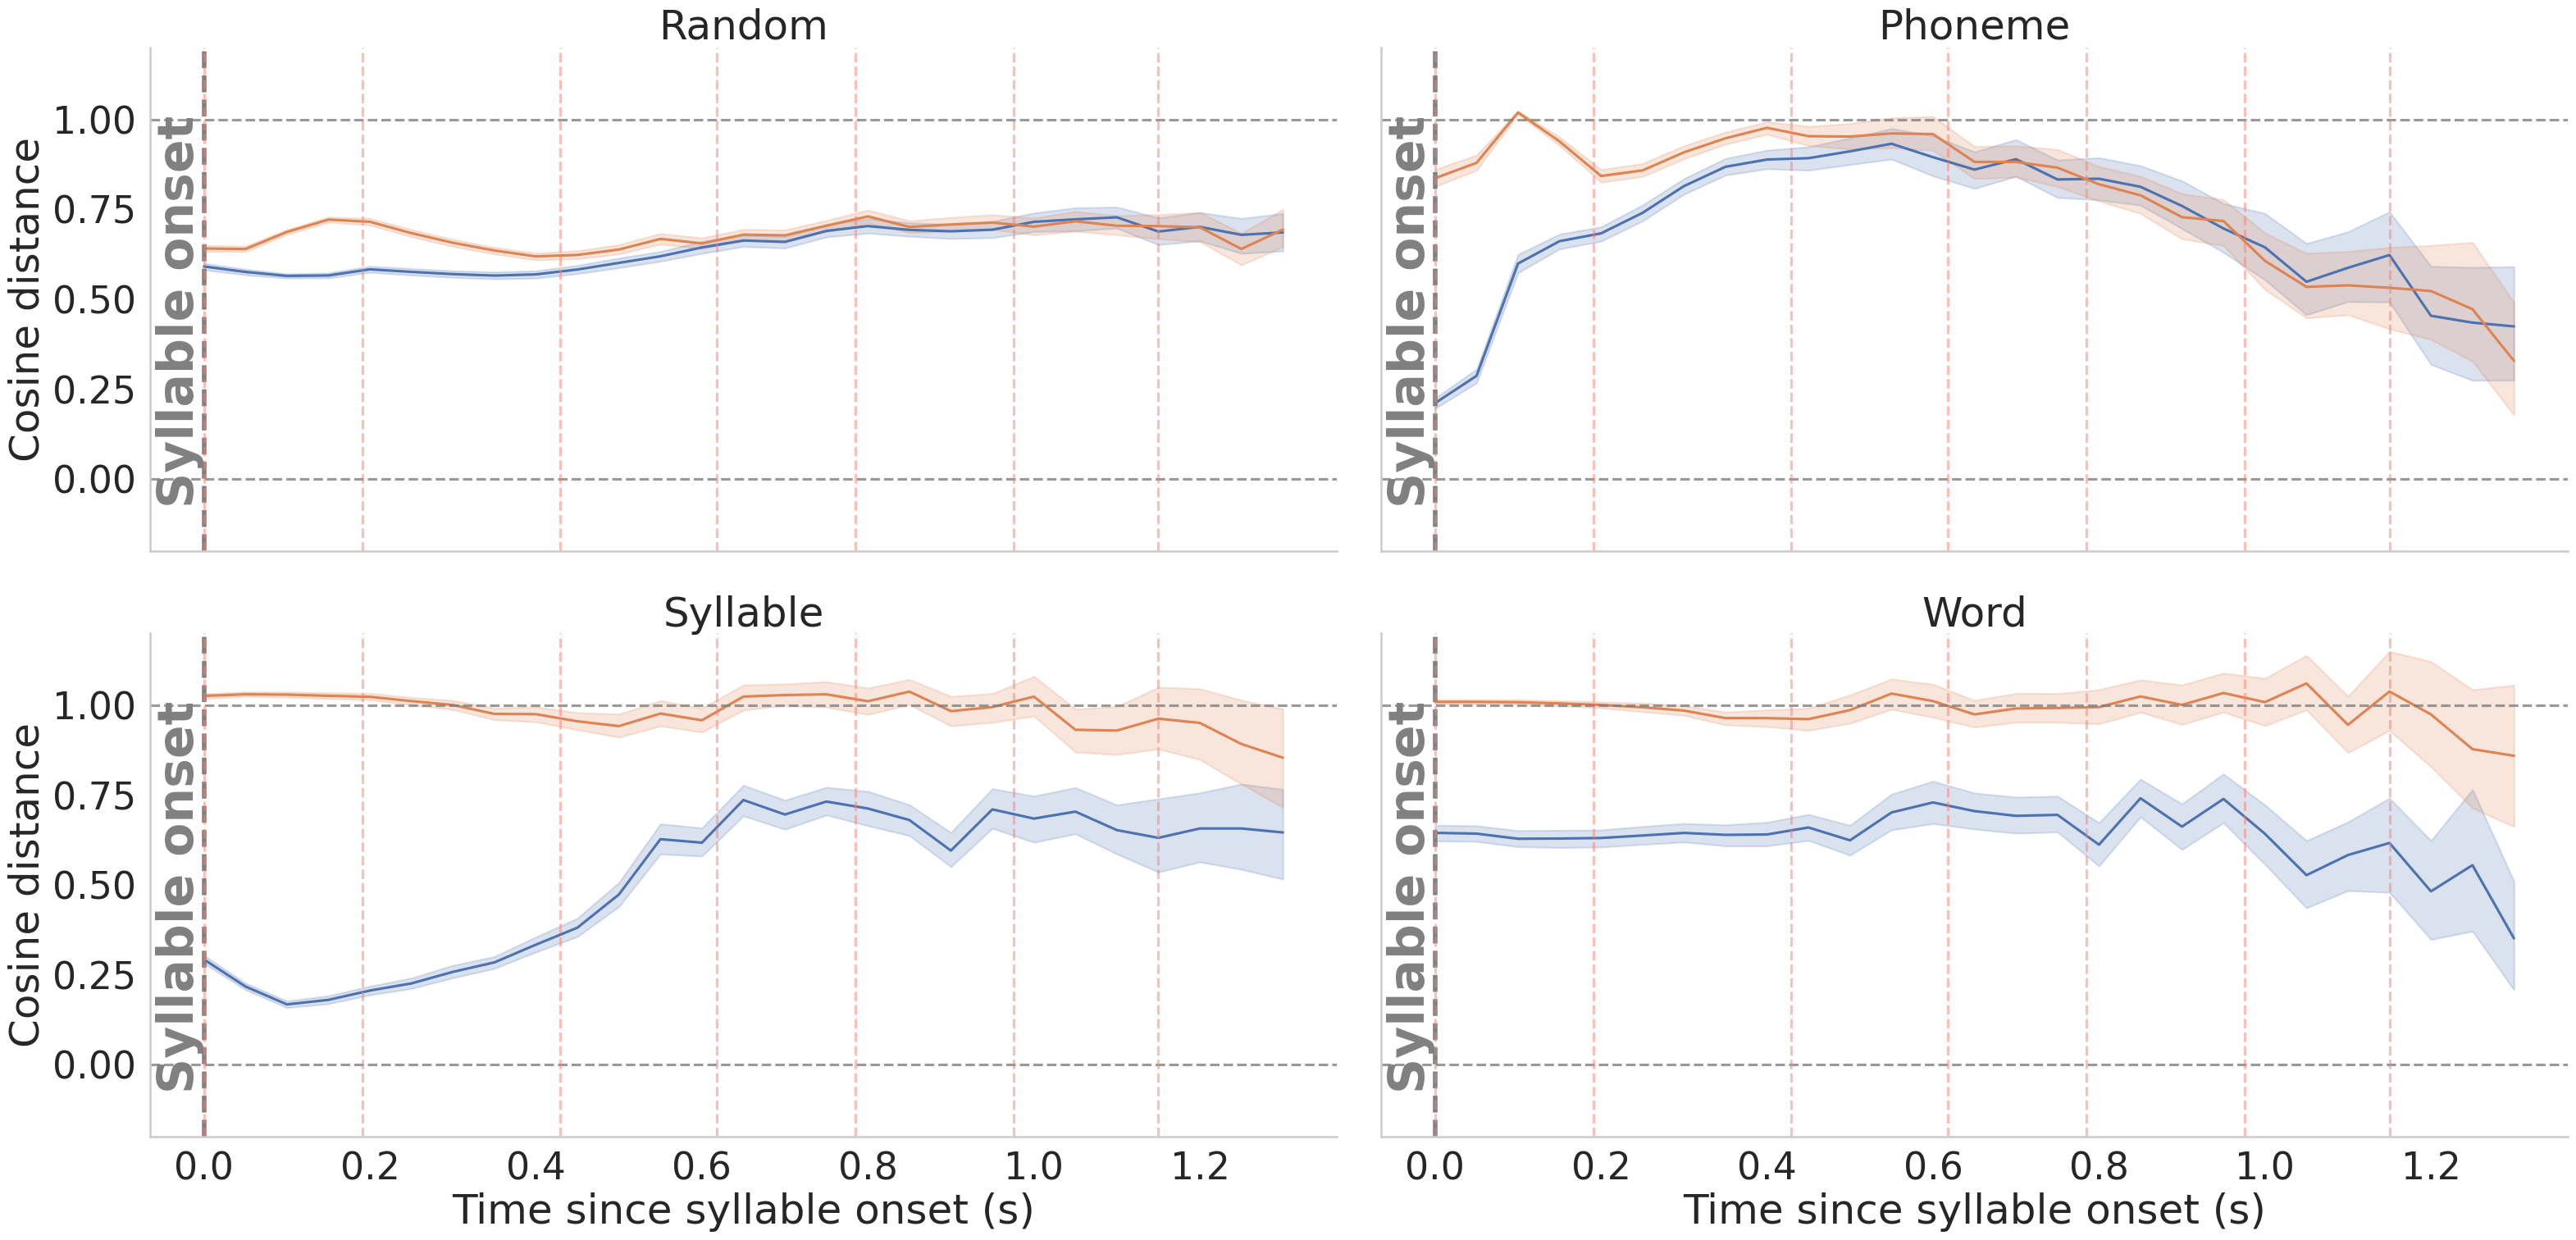

In [50]:
g = plot_coherence(syll_onset_distance_df, "syllable", plot_phonemes=phoneme_in_syllable_mean_onsets)

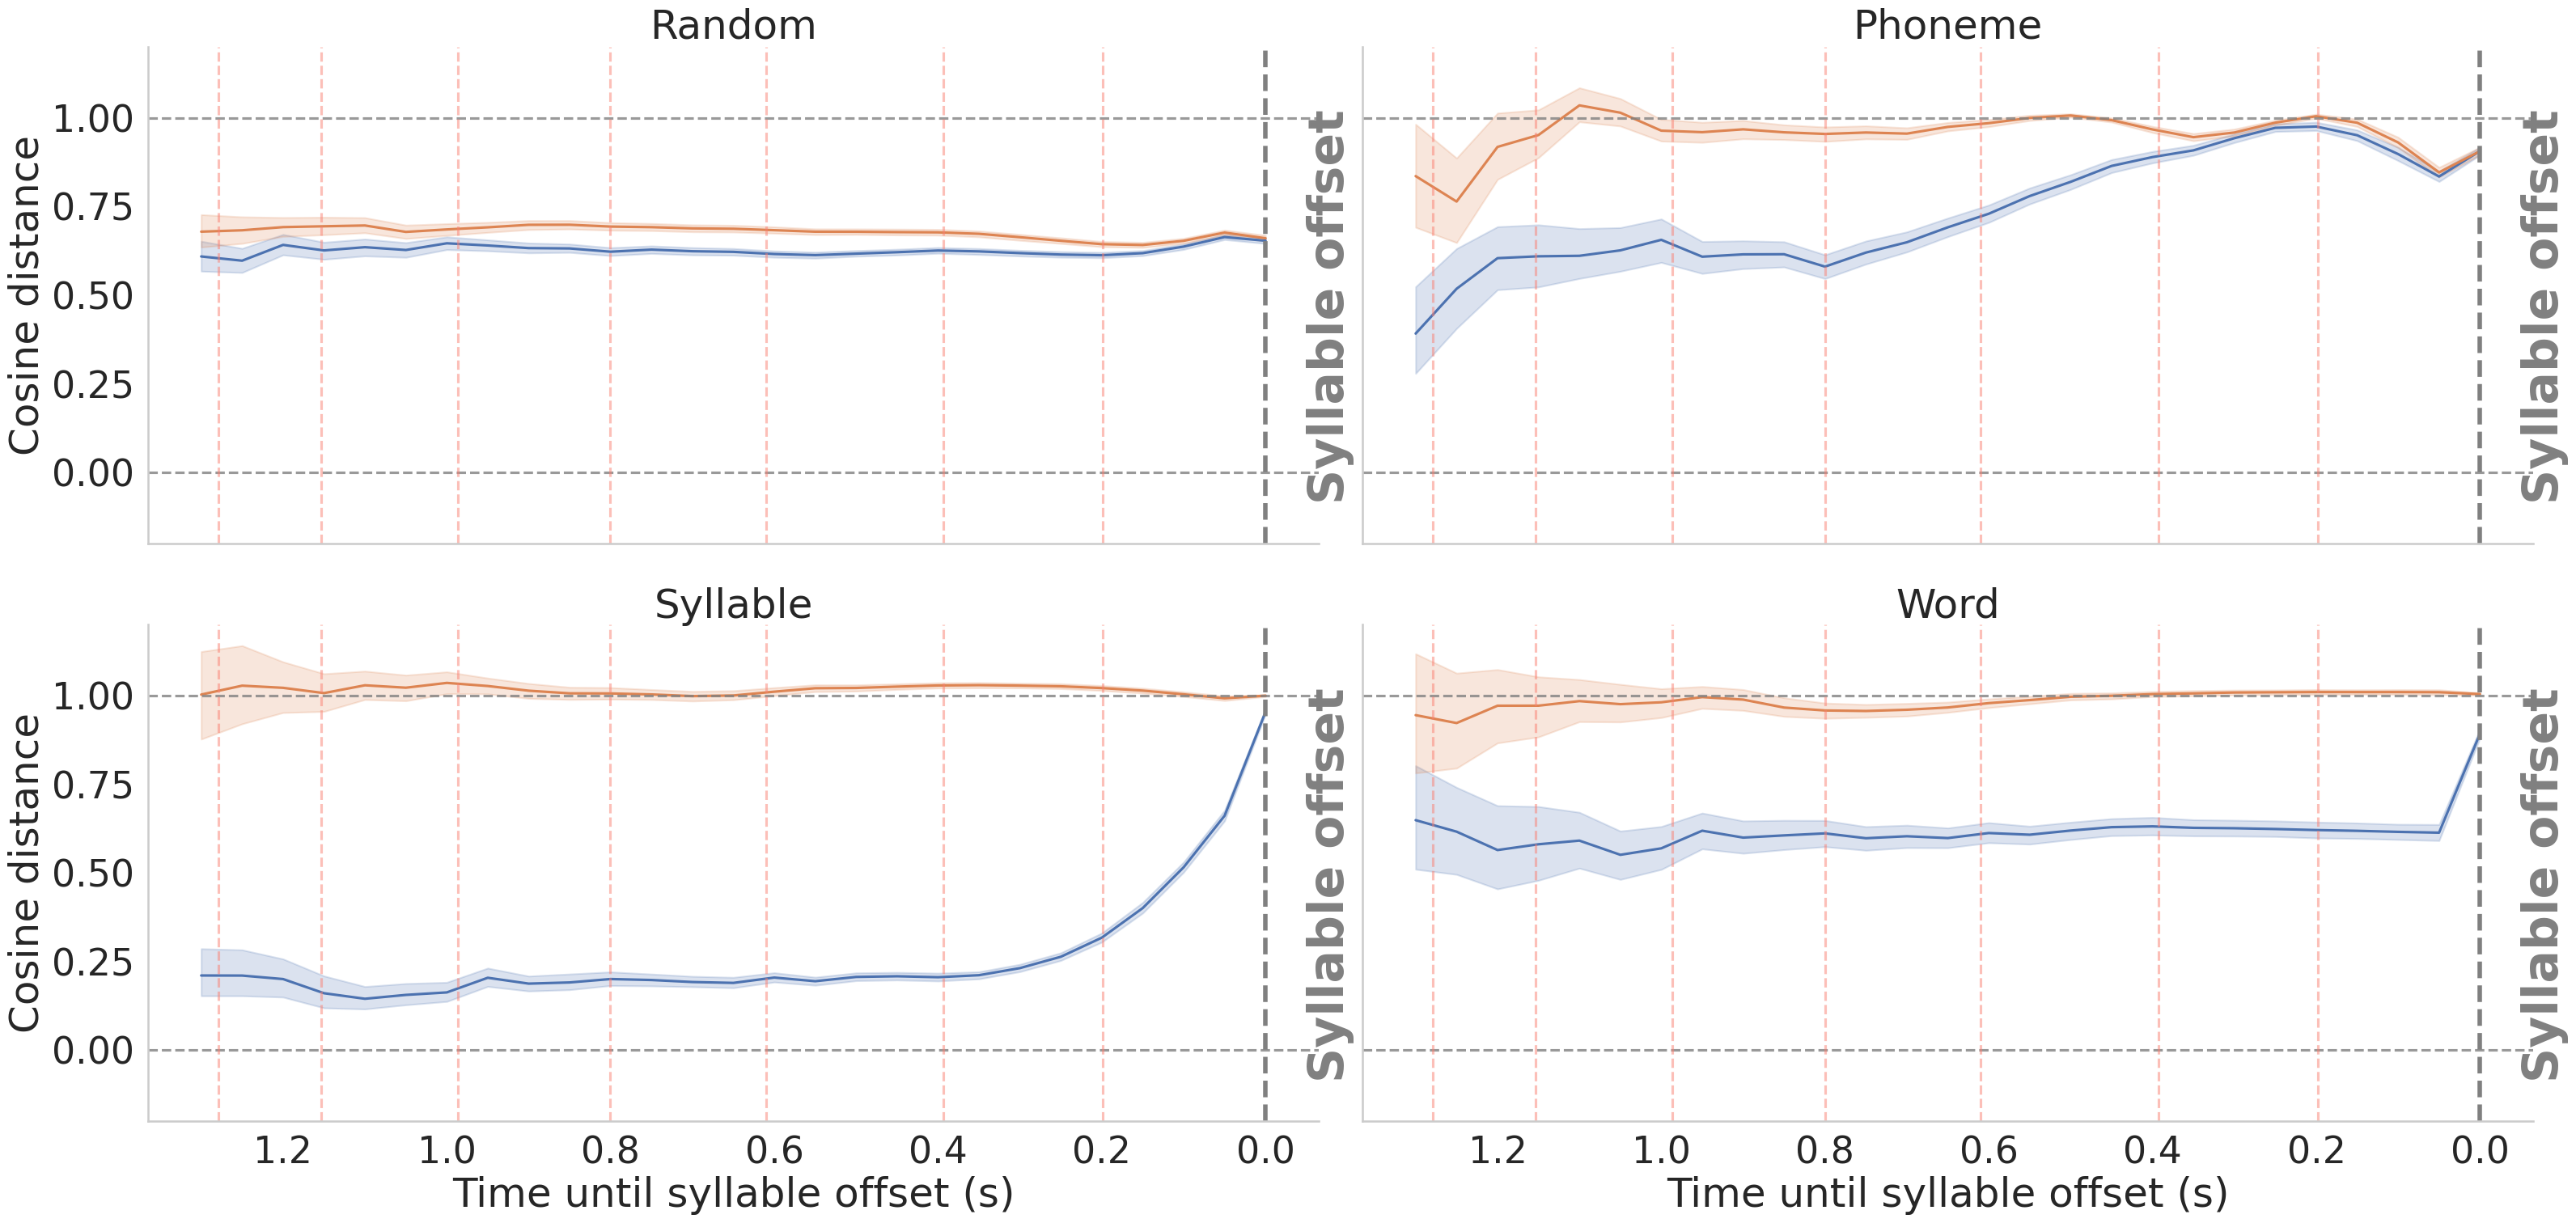

In [62]:
g = plot_coherence(syll_onset_distance_align_offset_df, "syllable", alignment="offset",
                   plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Grouped by nucleus

In [25]:
syll_nucleus_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus.csv", plot_models, plot_equivalences)
syll_nucleus_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus_aligned_offset.csv", plot_models, plot_equivalences)

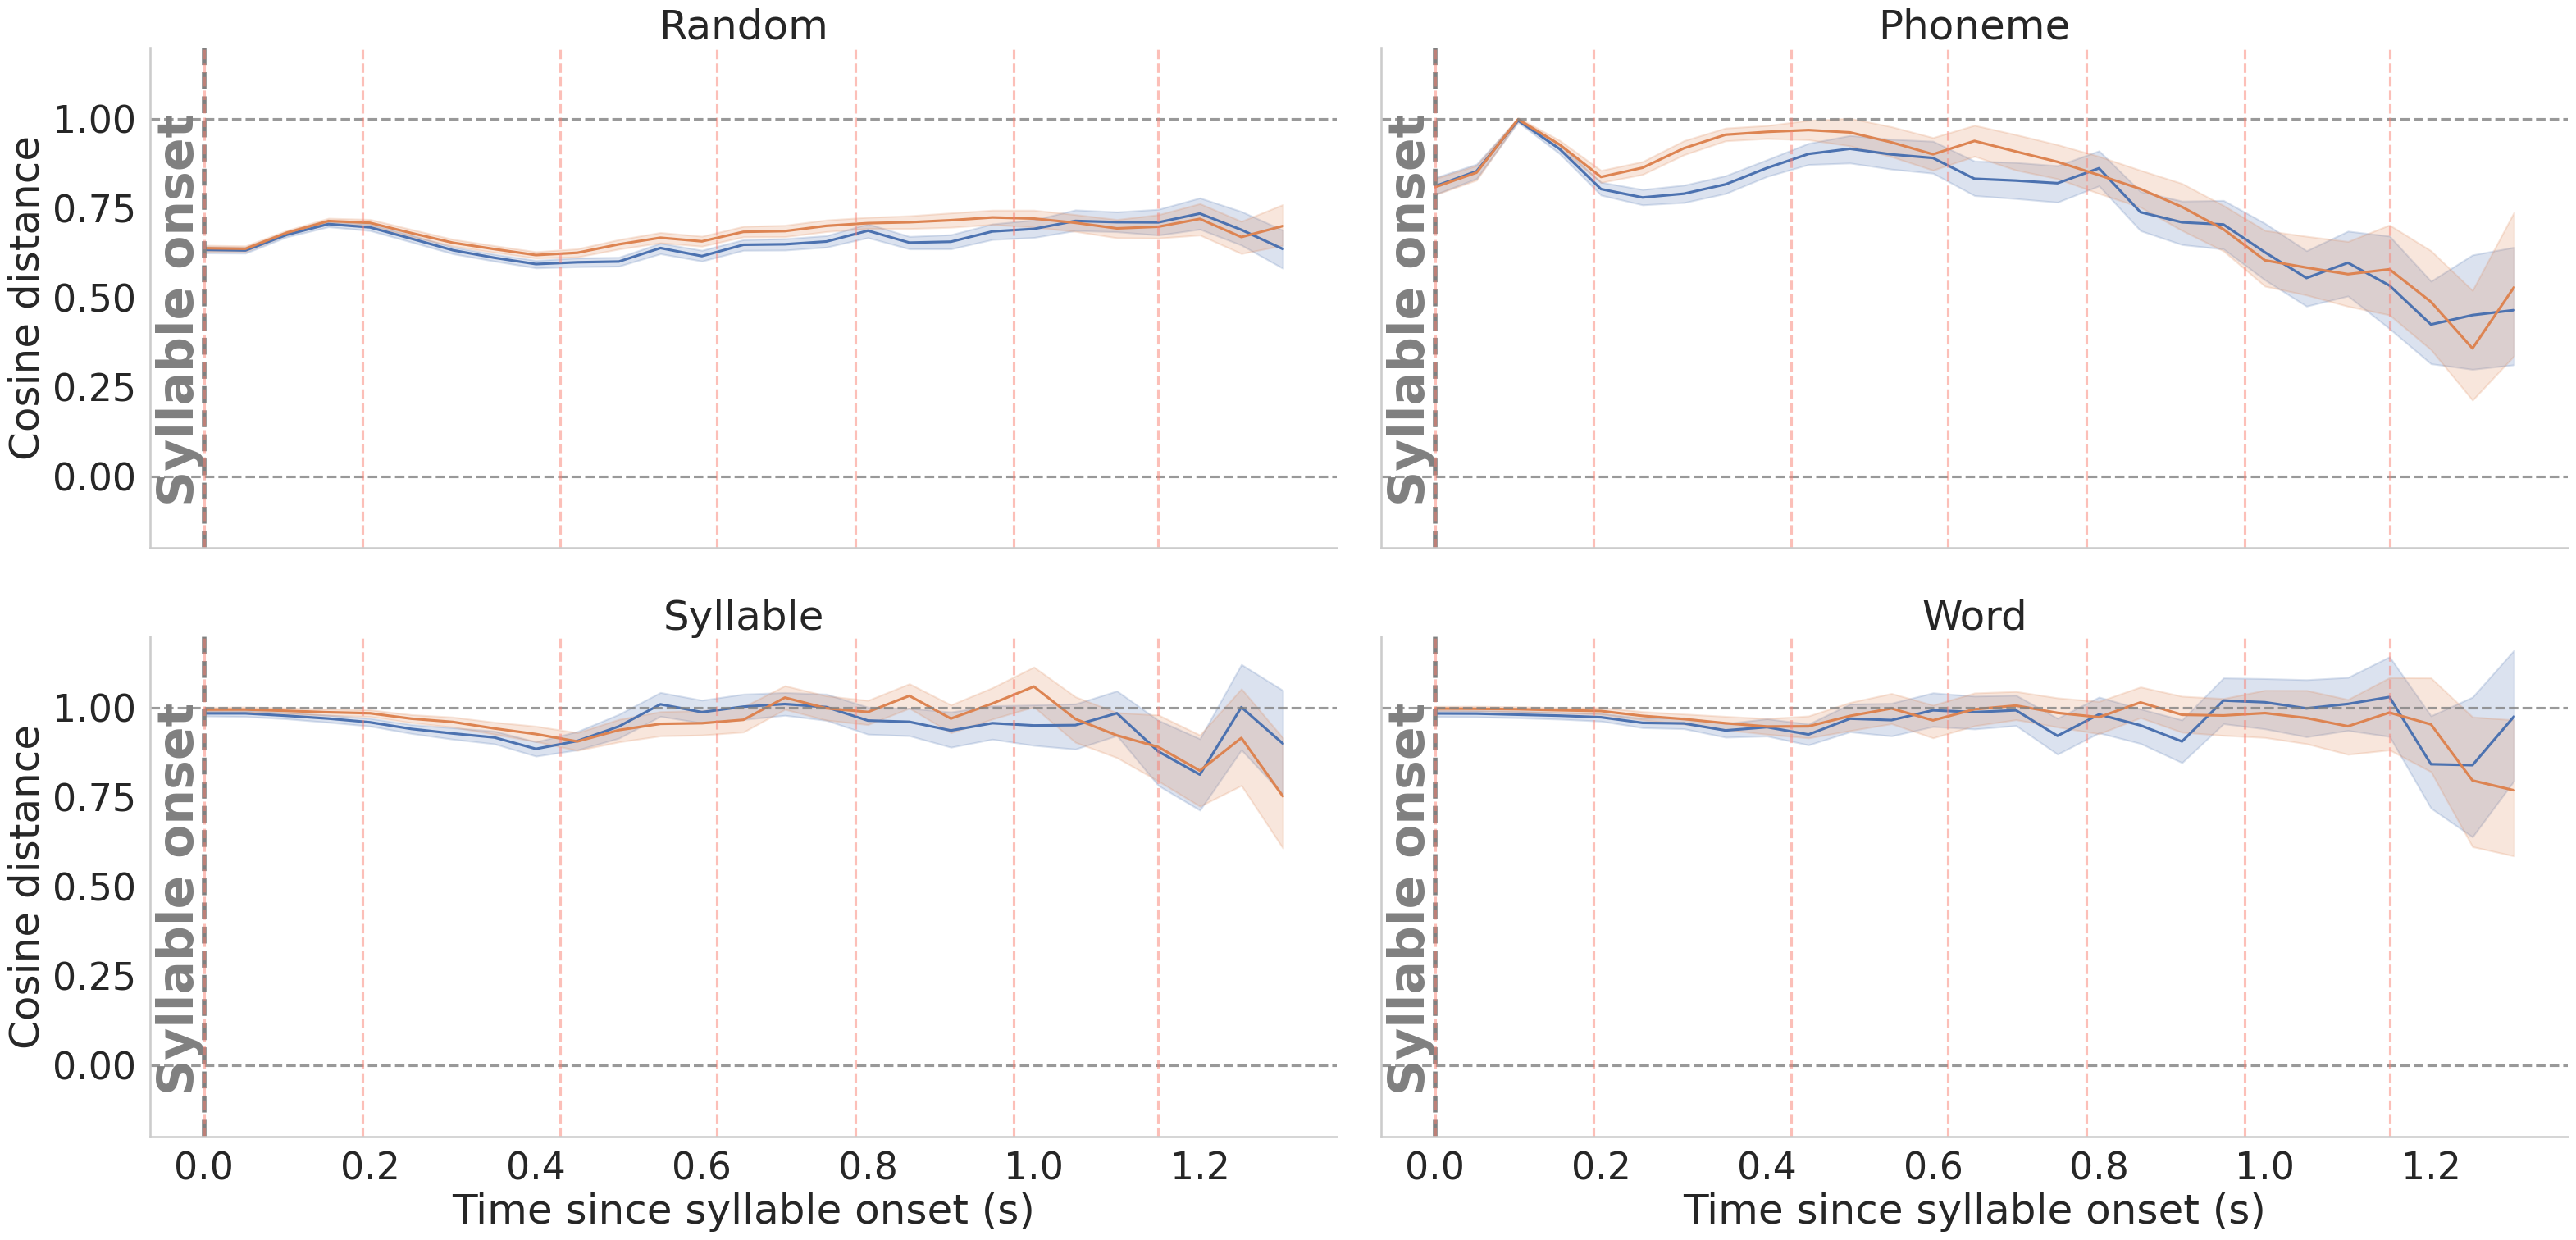

In [63]:
plot_coherence(syll_nucleus_distance_df, "syllable", plot_phonemes=phoneme_in_syllable_mean_onsets)

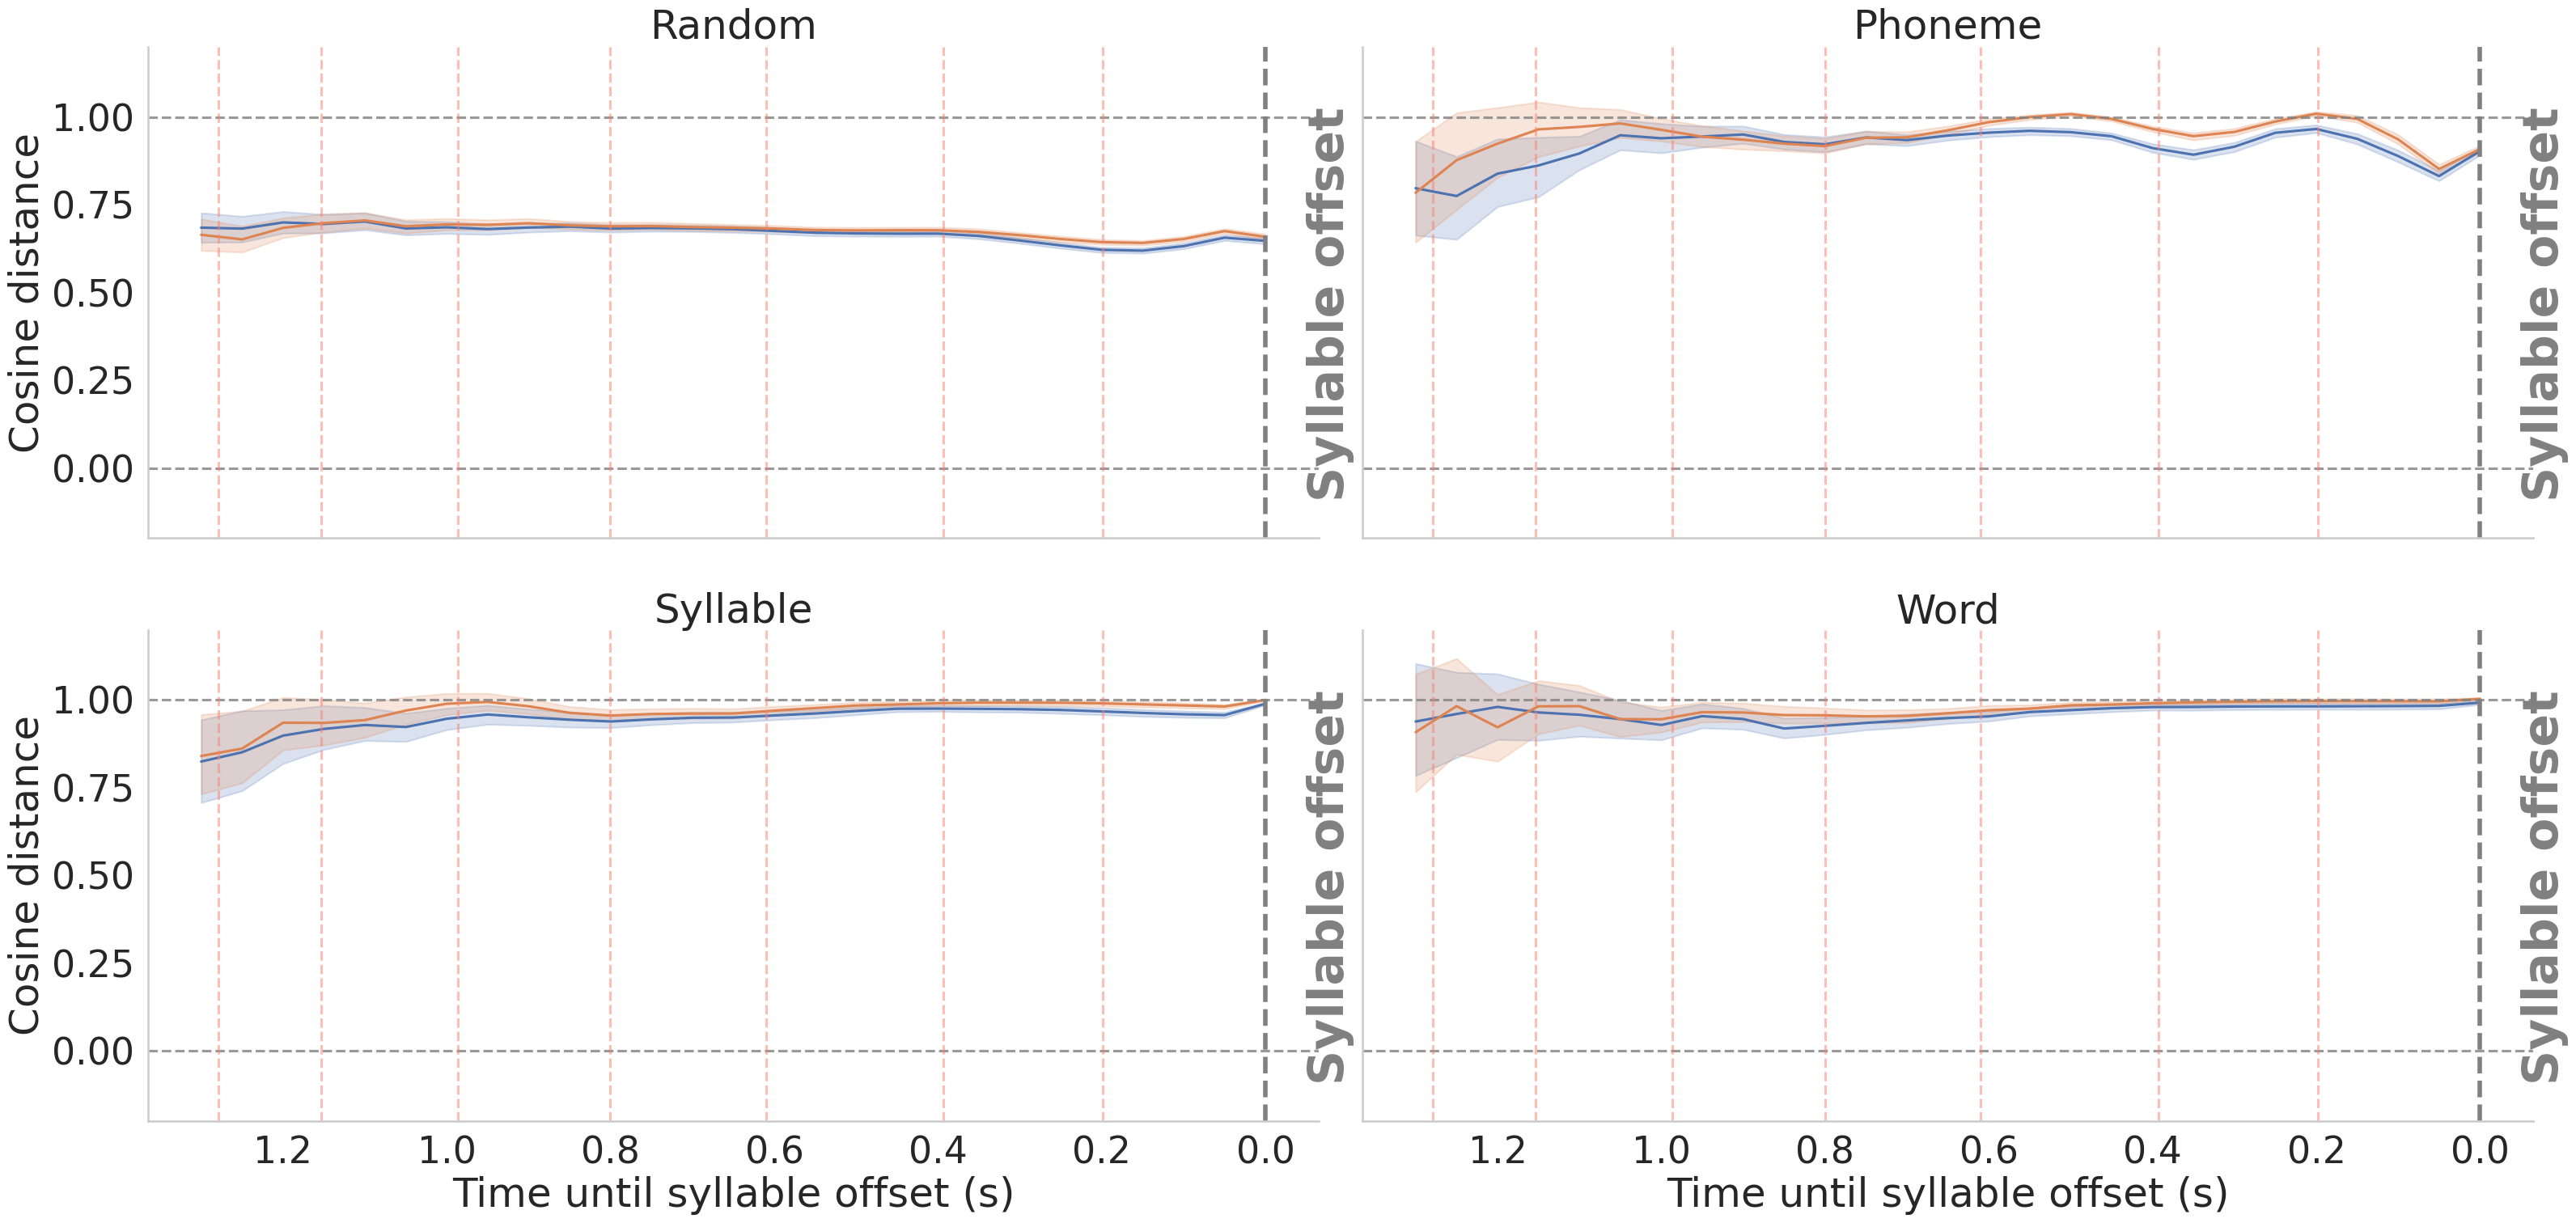

In [64]:
plot_coherence(syll_nucleus_distance_align_offset_df, "syllable", alignment="offset",
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Onset vs. nucleus

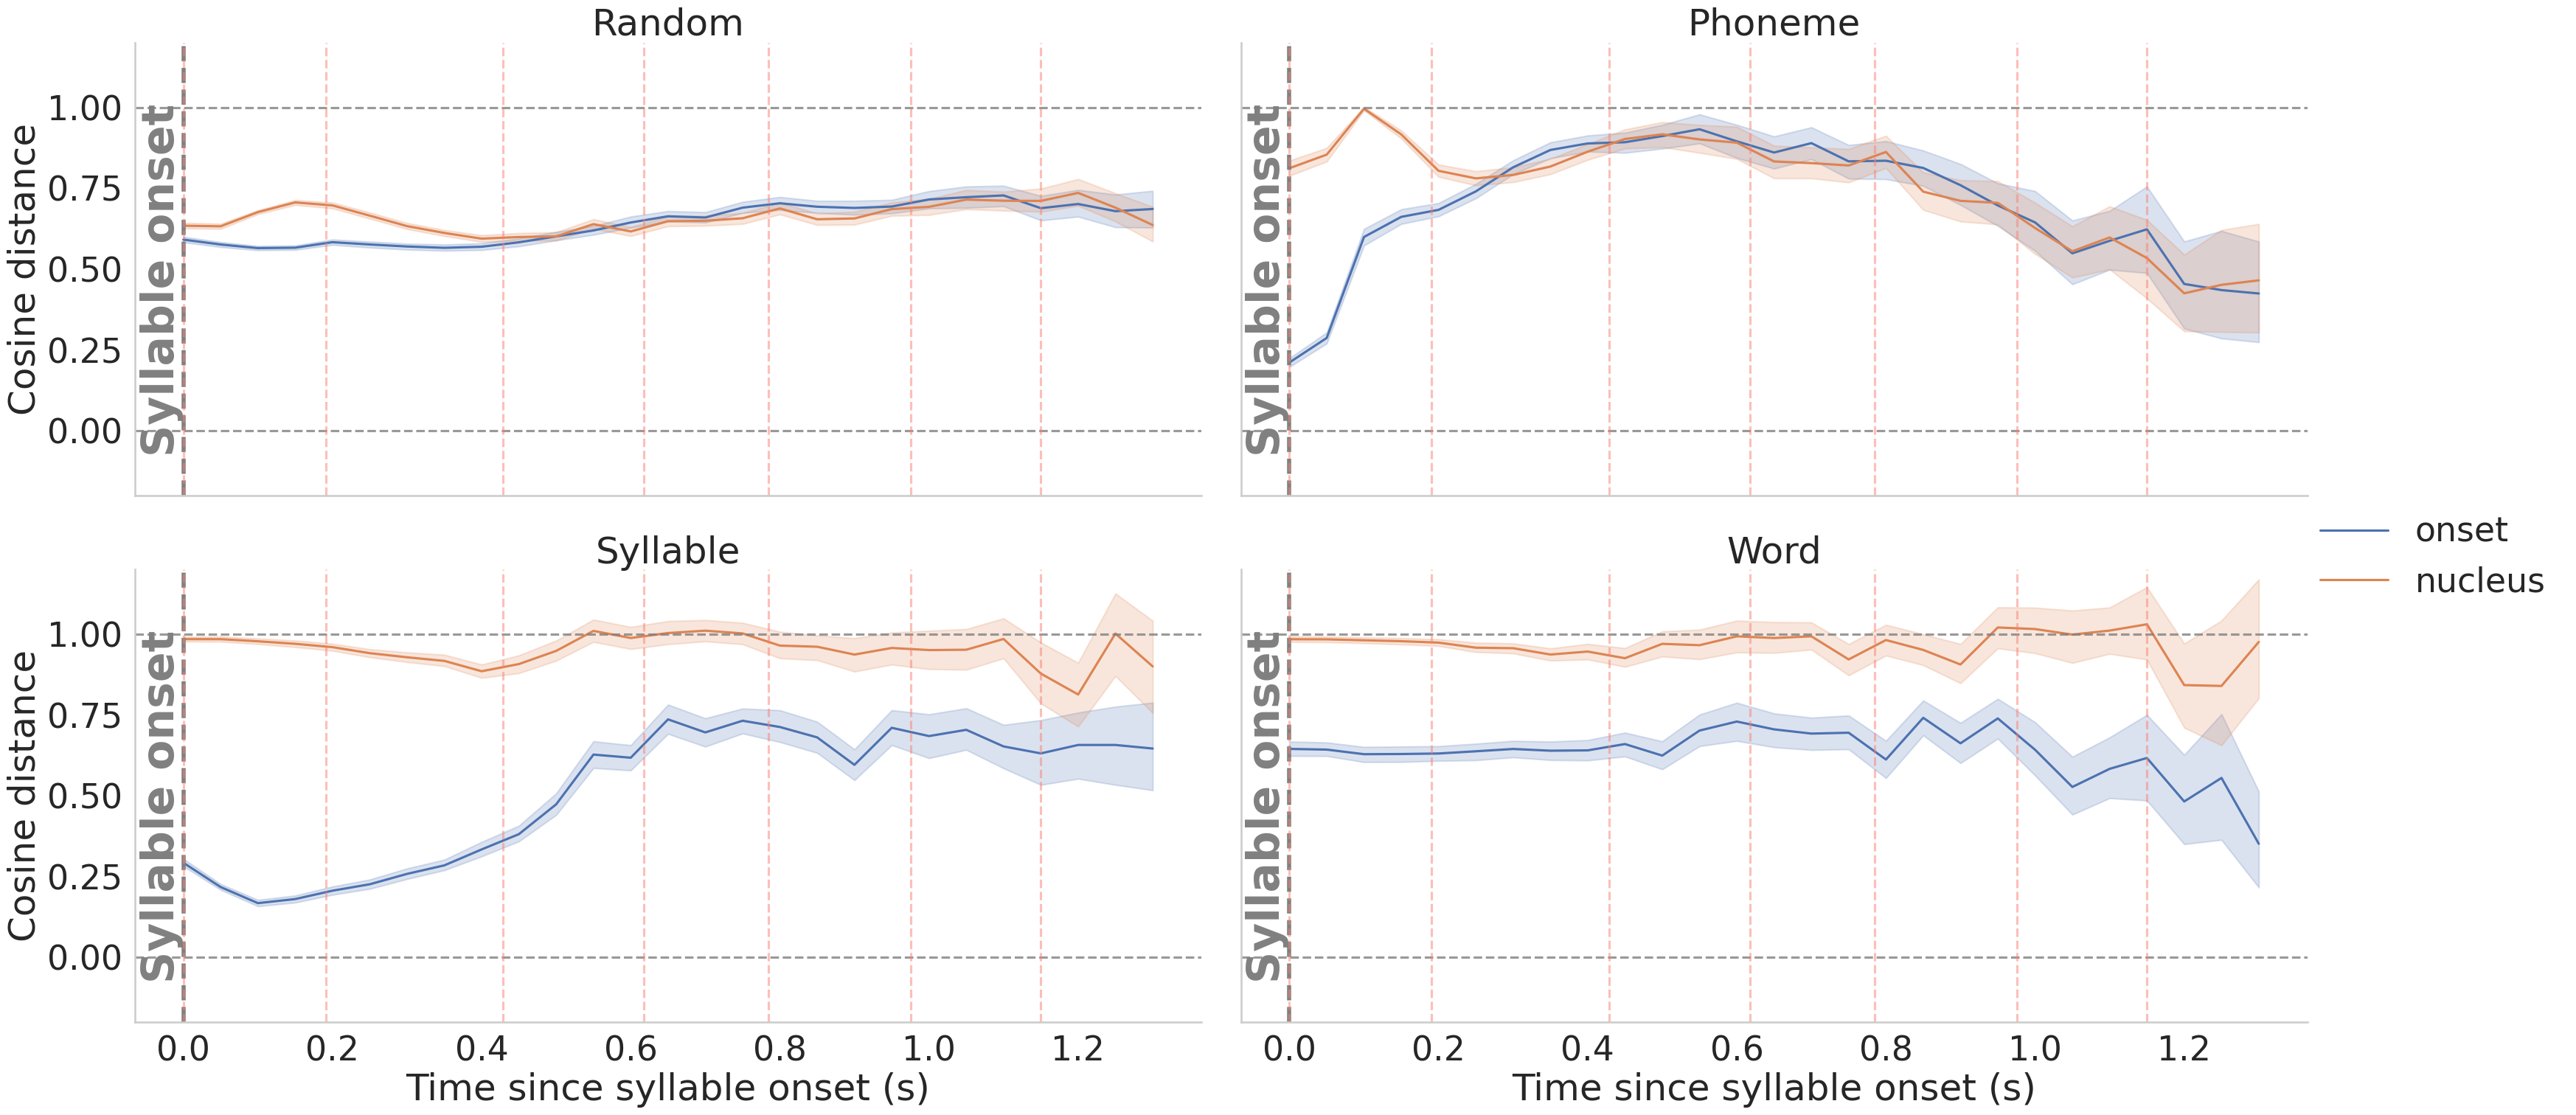

In [60]:
syll_merged_df = pd.concat([syll_onset_distance_df, syll_nucleus_distance_df], keys=["onset", "nucleus"], names=["match_type"])
syll_merged_df = syll_merged_df[syll_merged_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_df.reset_index(), "syllable", hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_mean_onsets, legend=True)

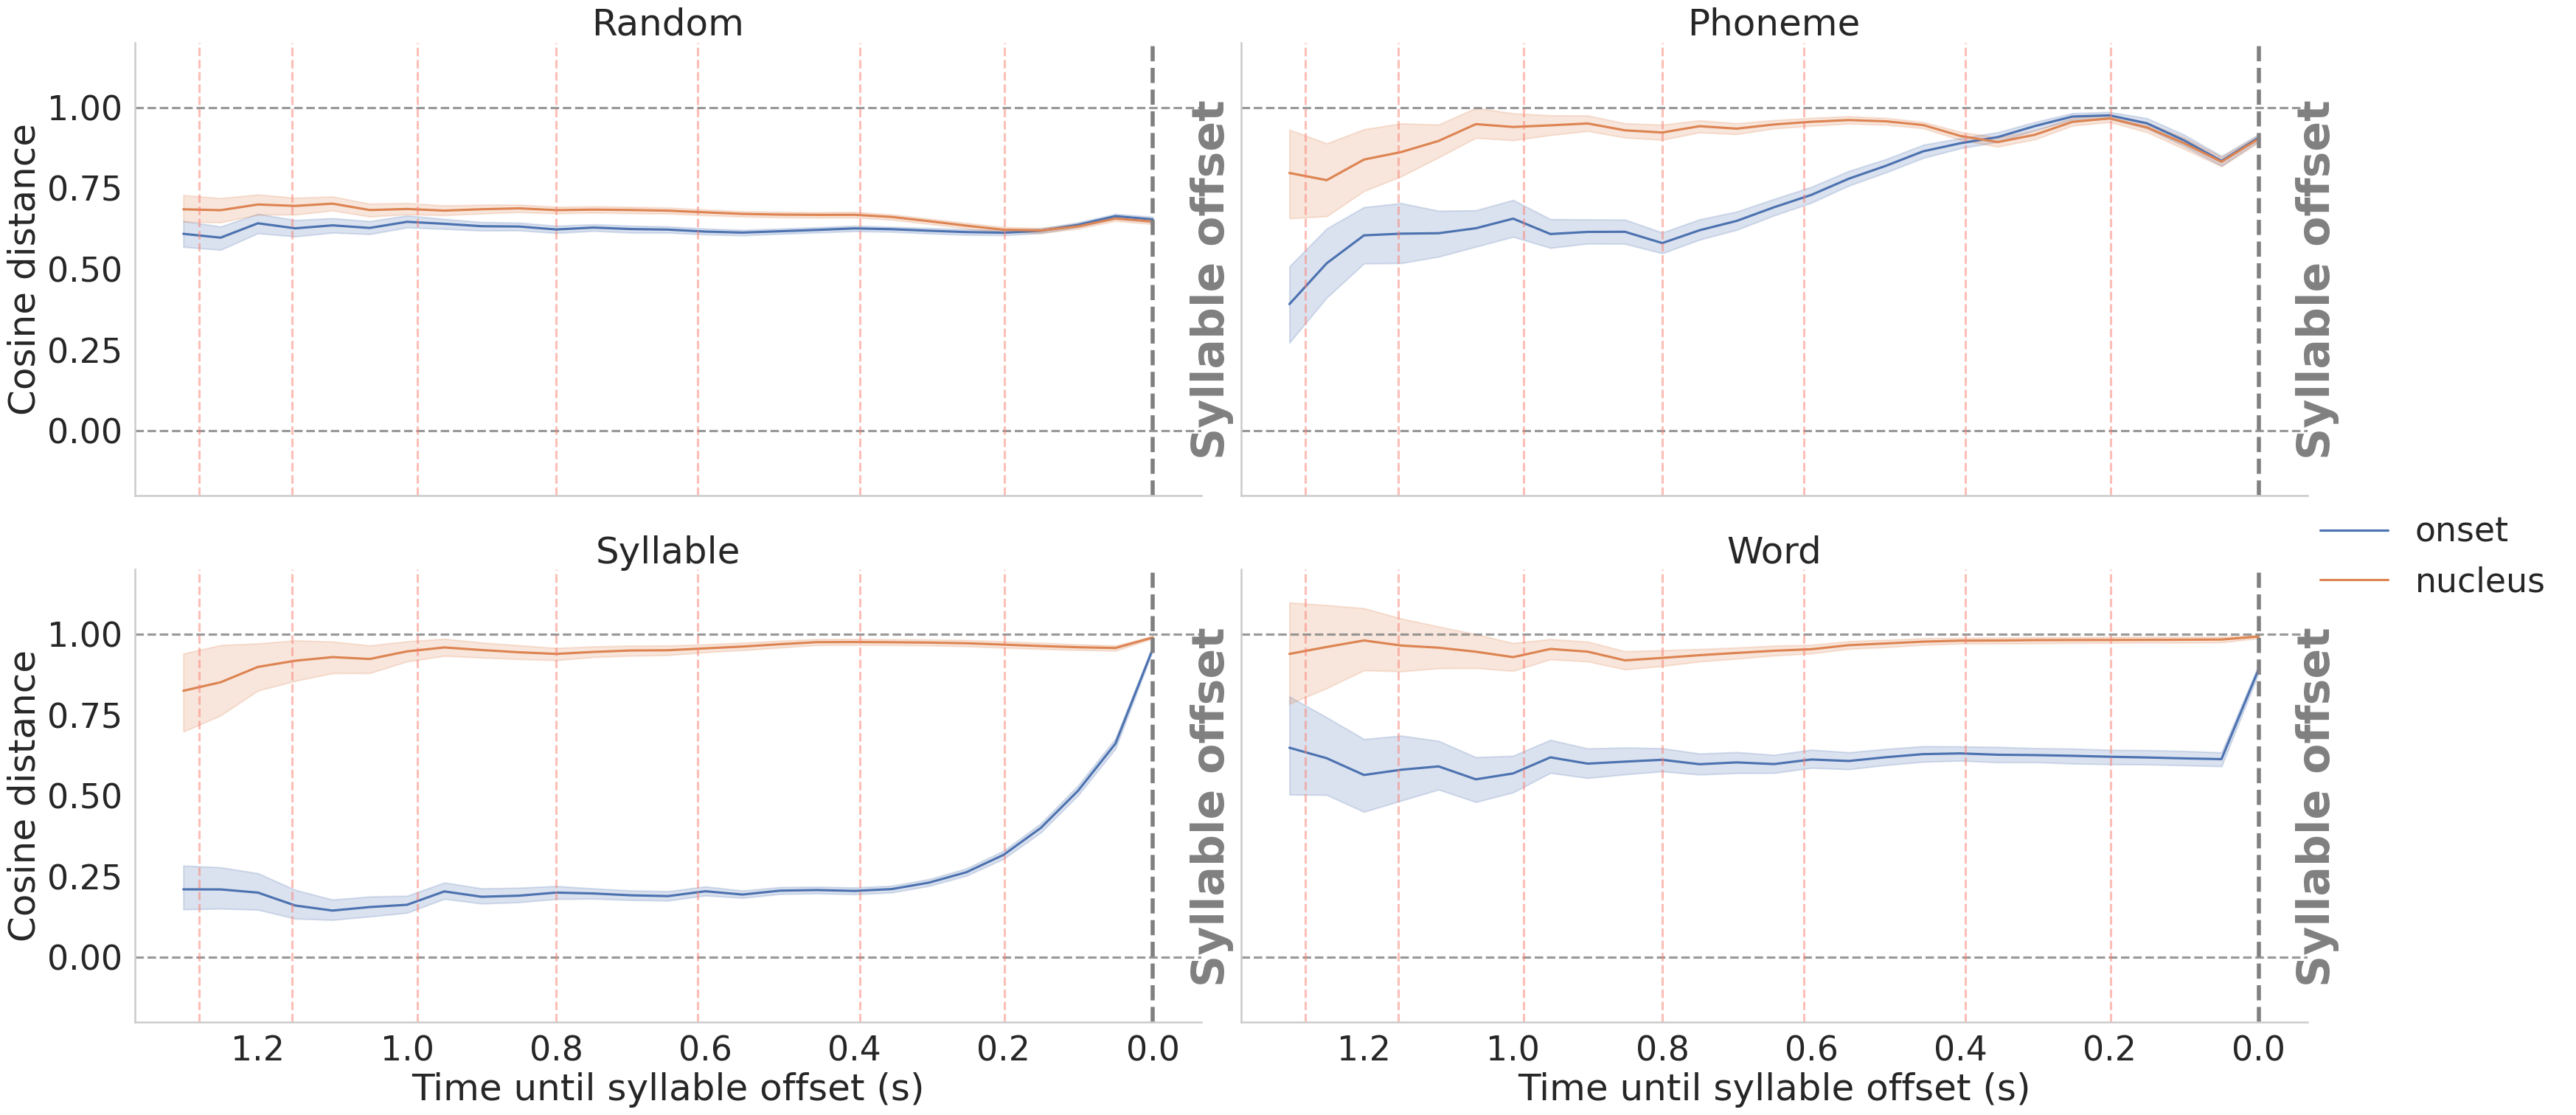

In [61]:
syll_merged_offset_df = pd.concat([syll_onset_distance_align_offset_df, syll_nucleus_distance_align_offset_df], 
                                  keys=["onset", "nucleus"], names=["match_type"])
syll_merged_offset_df = syll_merged_offset_df[syll_merged_offset_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_offset_df.reset_index(), "syllable", alignment="offset",
               hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets, legend=True)

## Word coherence

In [20]:
word_distance_df = load_grouped_distances("**/lexical_coherence/distances.csv", plot_models, plot_equivalences)
word_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances_aligned_offset.csv", plot_models, plot_equivalences)

In [21]:
# DEV
word_distance_df["time"] = word_distance_df["frame"] / 20
word_distance_align_offset_df["time"] = (word_distance_align_offset_df["frame"] - 1) / 20

In [30]:
sorted(word_distance_df.word.unique())[50:]

['boy',
 'breakfast',
 'bright',
 'brother',
 'but',
 'buy',
 'by',
 'came',
 'can',
 'carry',
 'cats',
 'caused',
 'change',
 'cheese',
 'child',
 'children',
 'church',
 'clay',
 'club',
 'coffee',
 'colorful',
 'come',
 'common',
 'cost',
 'costumes',
 'could',
 'course',
 'cream',
 'critical',
 'curiosity',
 'cut',
 'dark',
 'data',
 'day',
 'deal',
 'dessert',
 'did',
 "didn't",
 'dinner',
 'disappeared',
 'do',
 'doctor',
 'does',
 'dog',
 "don't",
 'door',
 'down',
 'draw',
 'each',
 'early',
 'easy',
 'eat',
 'eating',
 'edge',
 'eight',
 'elm',
 'else',
 'enjoy',
 'enough',
 'enter',
 'equipment',
 'essay',
 'even',
 'evening',
 'ever',
 'every',
 'evidence',
 'examples',
 'experience',
 'extra',
 'eyes',
 'face',
 'farm',
 'feet',
 'files',
 'fill',
 'film',
 'first',
 'for',
 'forces',
 'forest',
 'found',
 'four',
 'freely',
 'frequently',
 'fresh',
 'from',
 'fruit',
 'full',
 'garden',
 'gas',
 'gave',
 'gently',
 'geological',
 'george',
 'get',
 'gift',
 'give',
 'go',


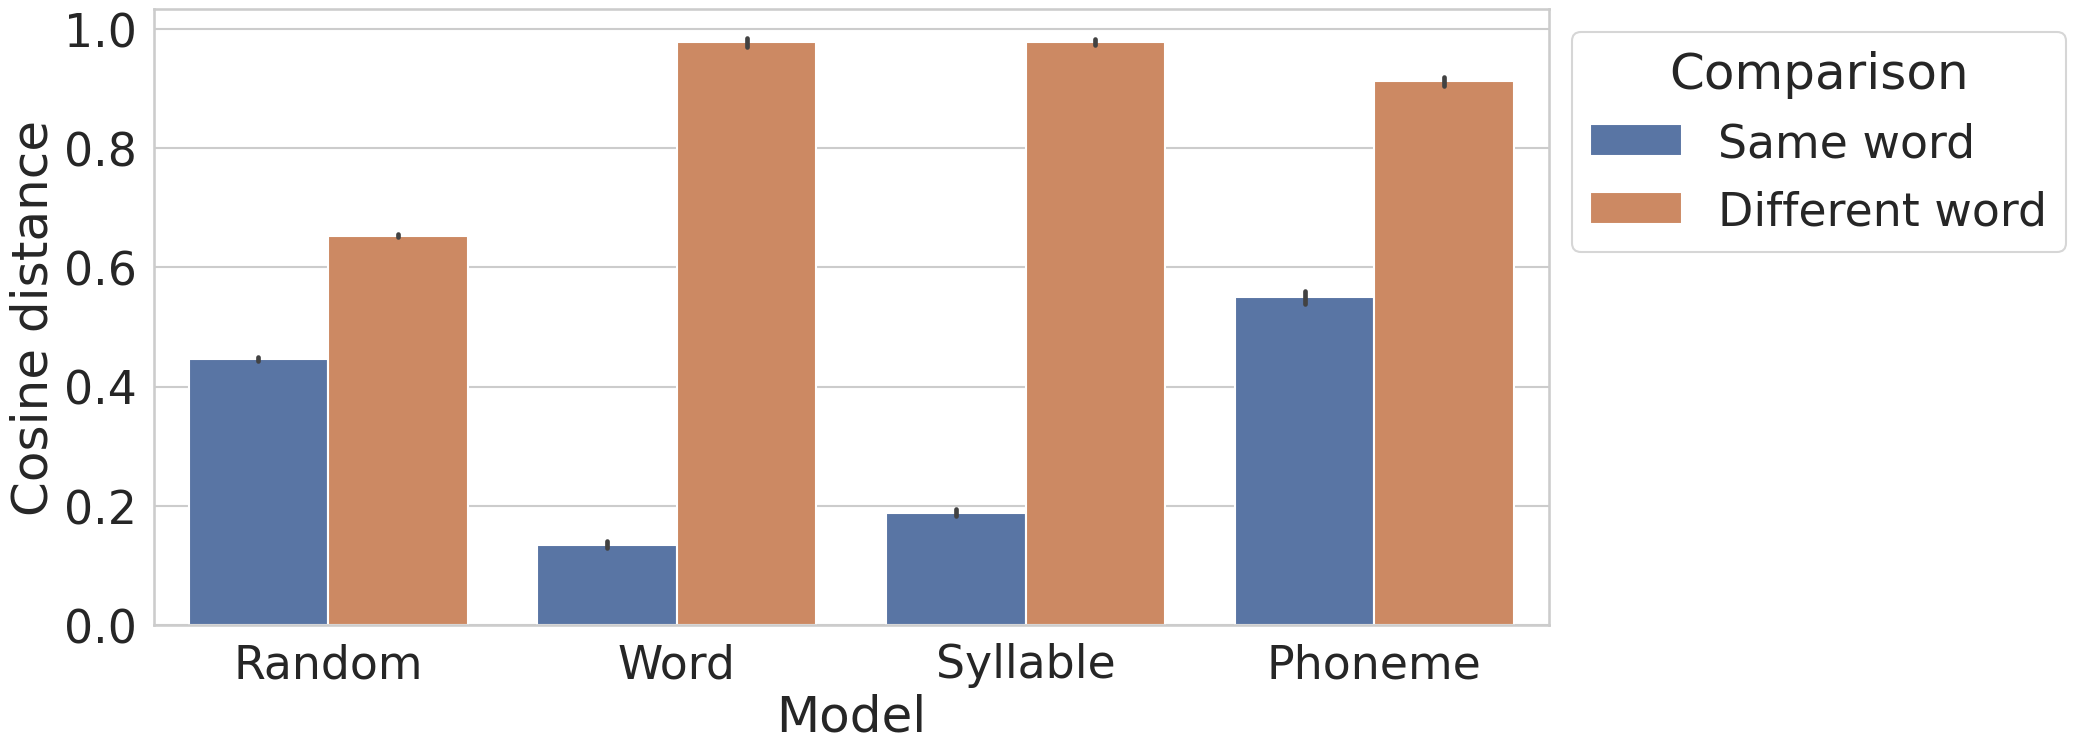

In [23]:
f, ax = plt.subplots(figsize=(18, 8))
word_plot_data = word_distance_df.reset_index()
word_plot_data["equivalence"] = word_plot_data["equivalence"].str.capitalize()
word_plot_data["type"] = word_plot_data["type"].map(
    {"within": "Same word",
     "between": "Different word"}
)
sns.barplot(data=word_plot_data,
            x="equivalence", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

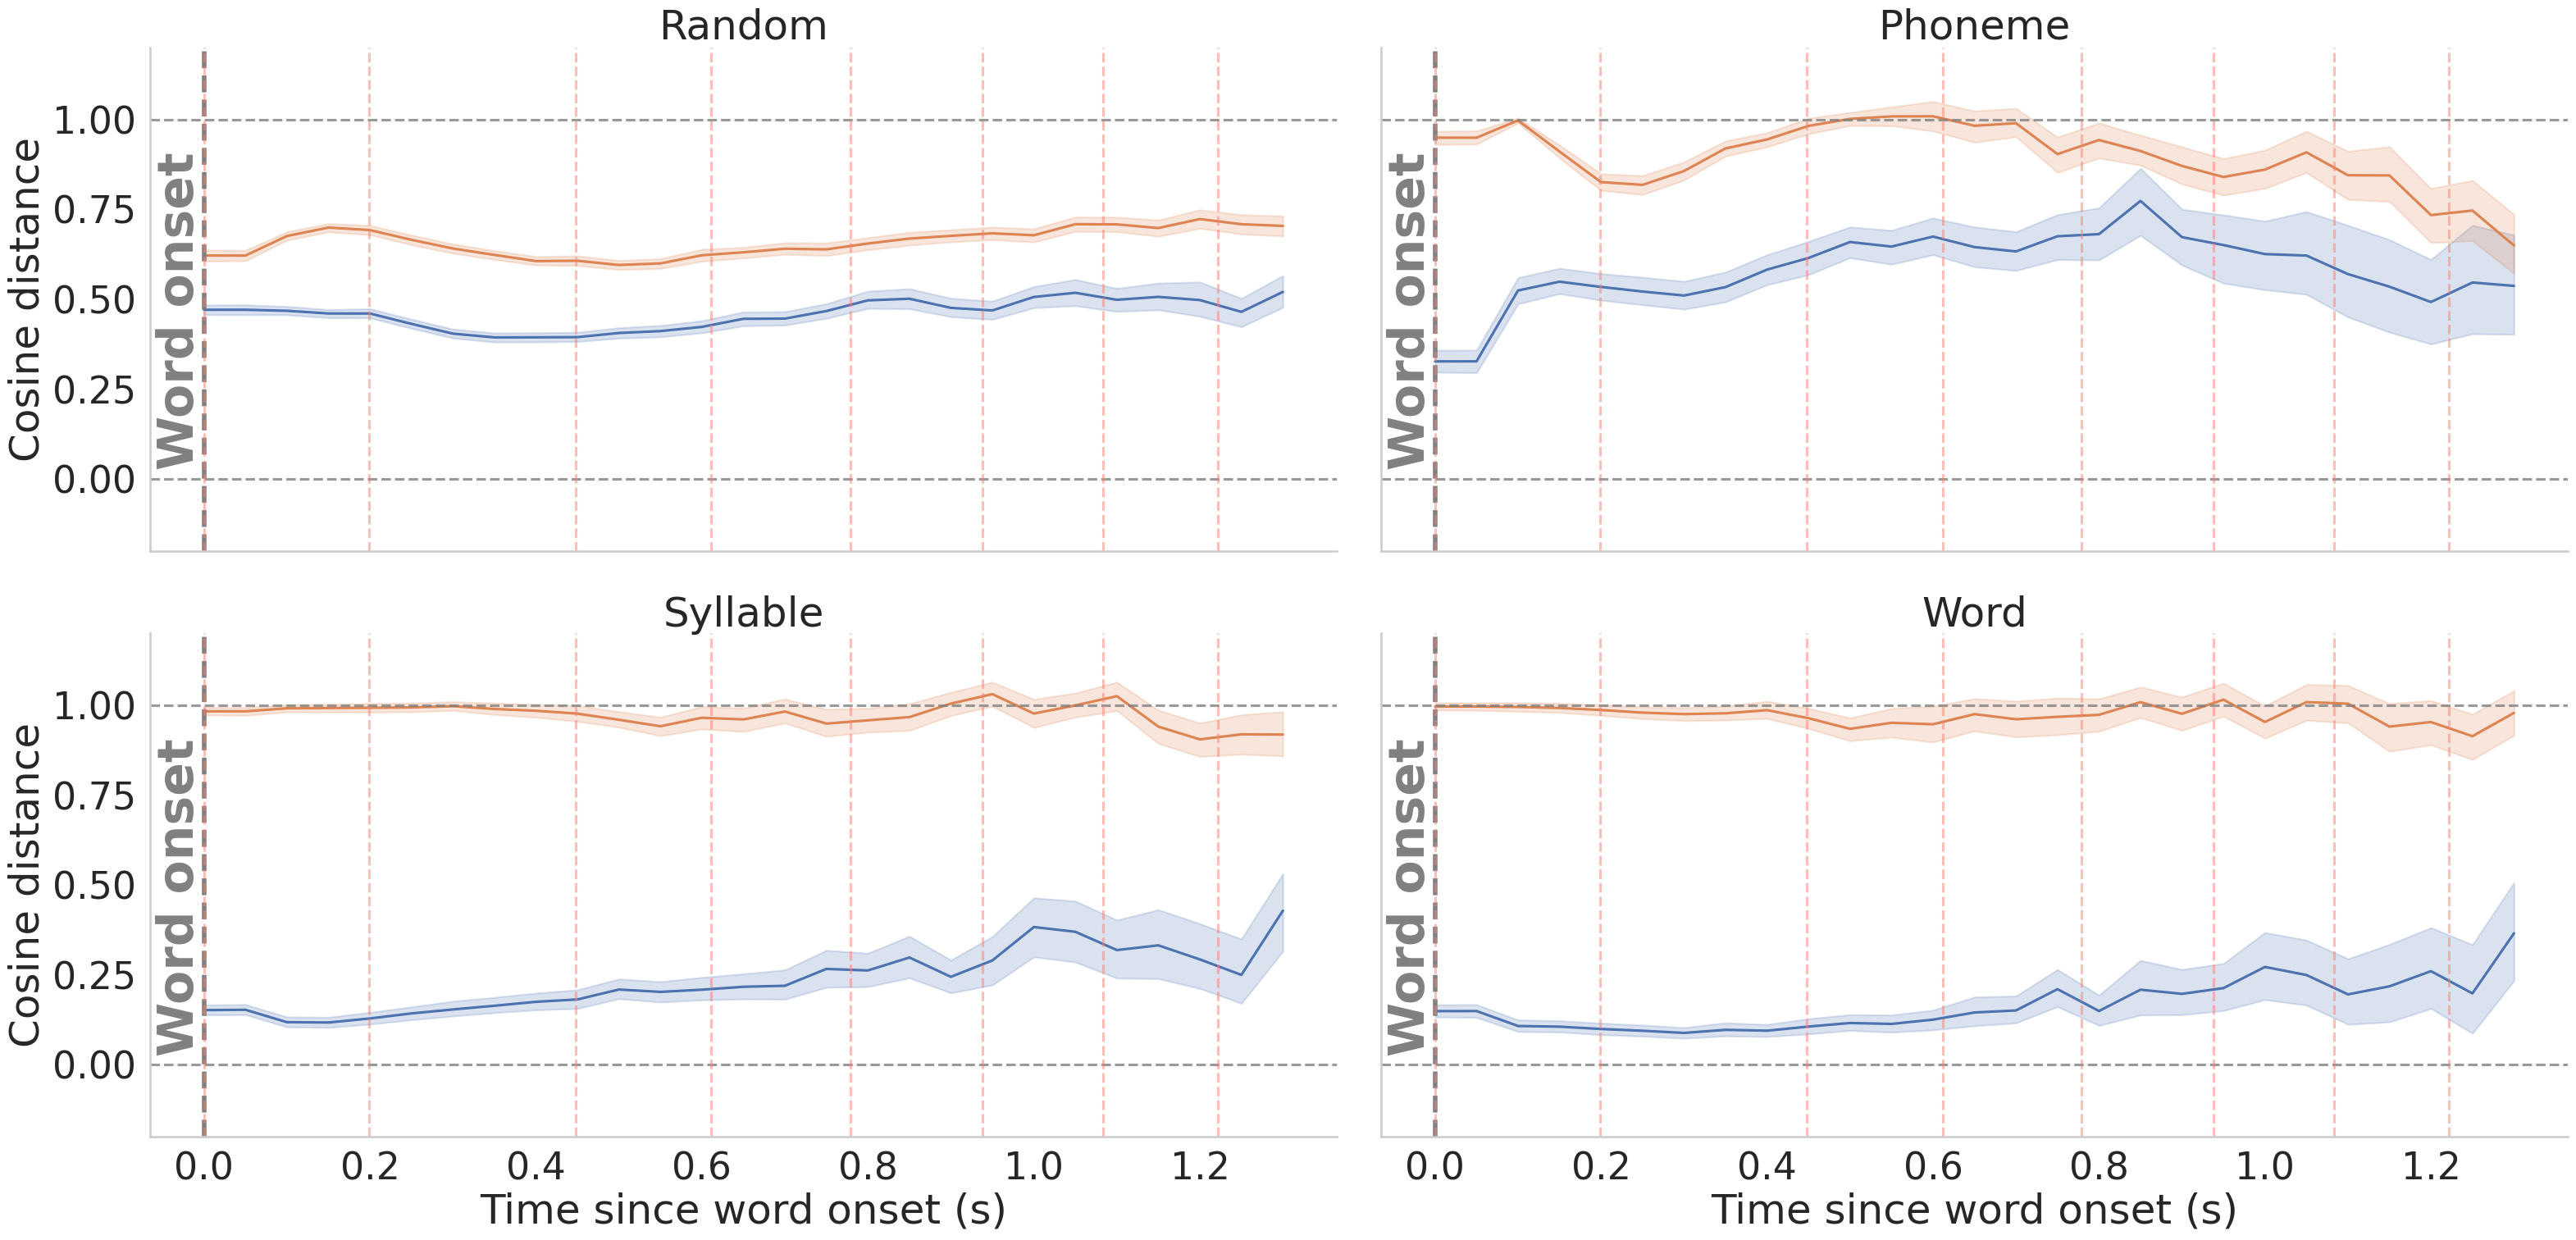

In [72]:
plot_coherence(word_distance_df, "word", plot_phonemes=phoneme_in_word_mean_onsets)

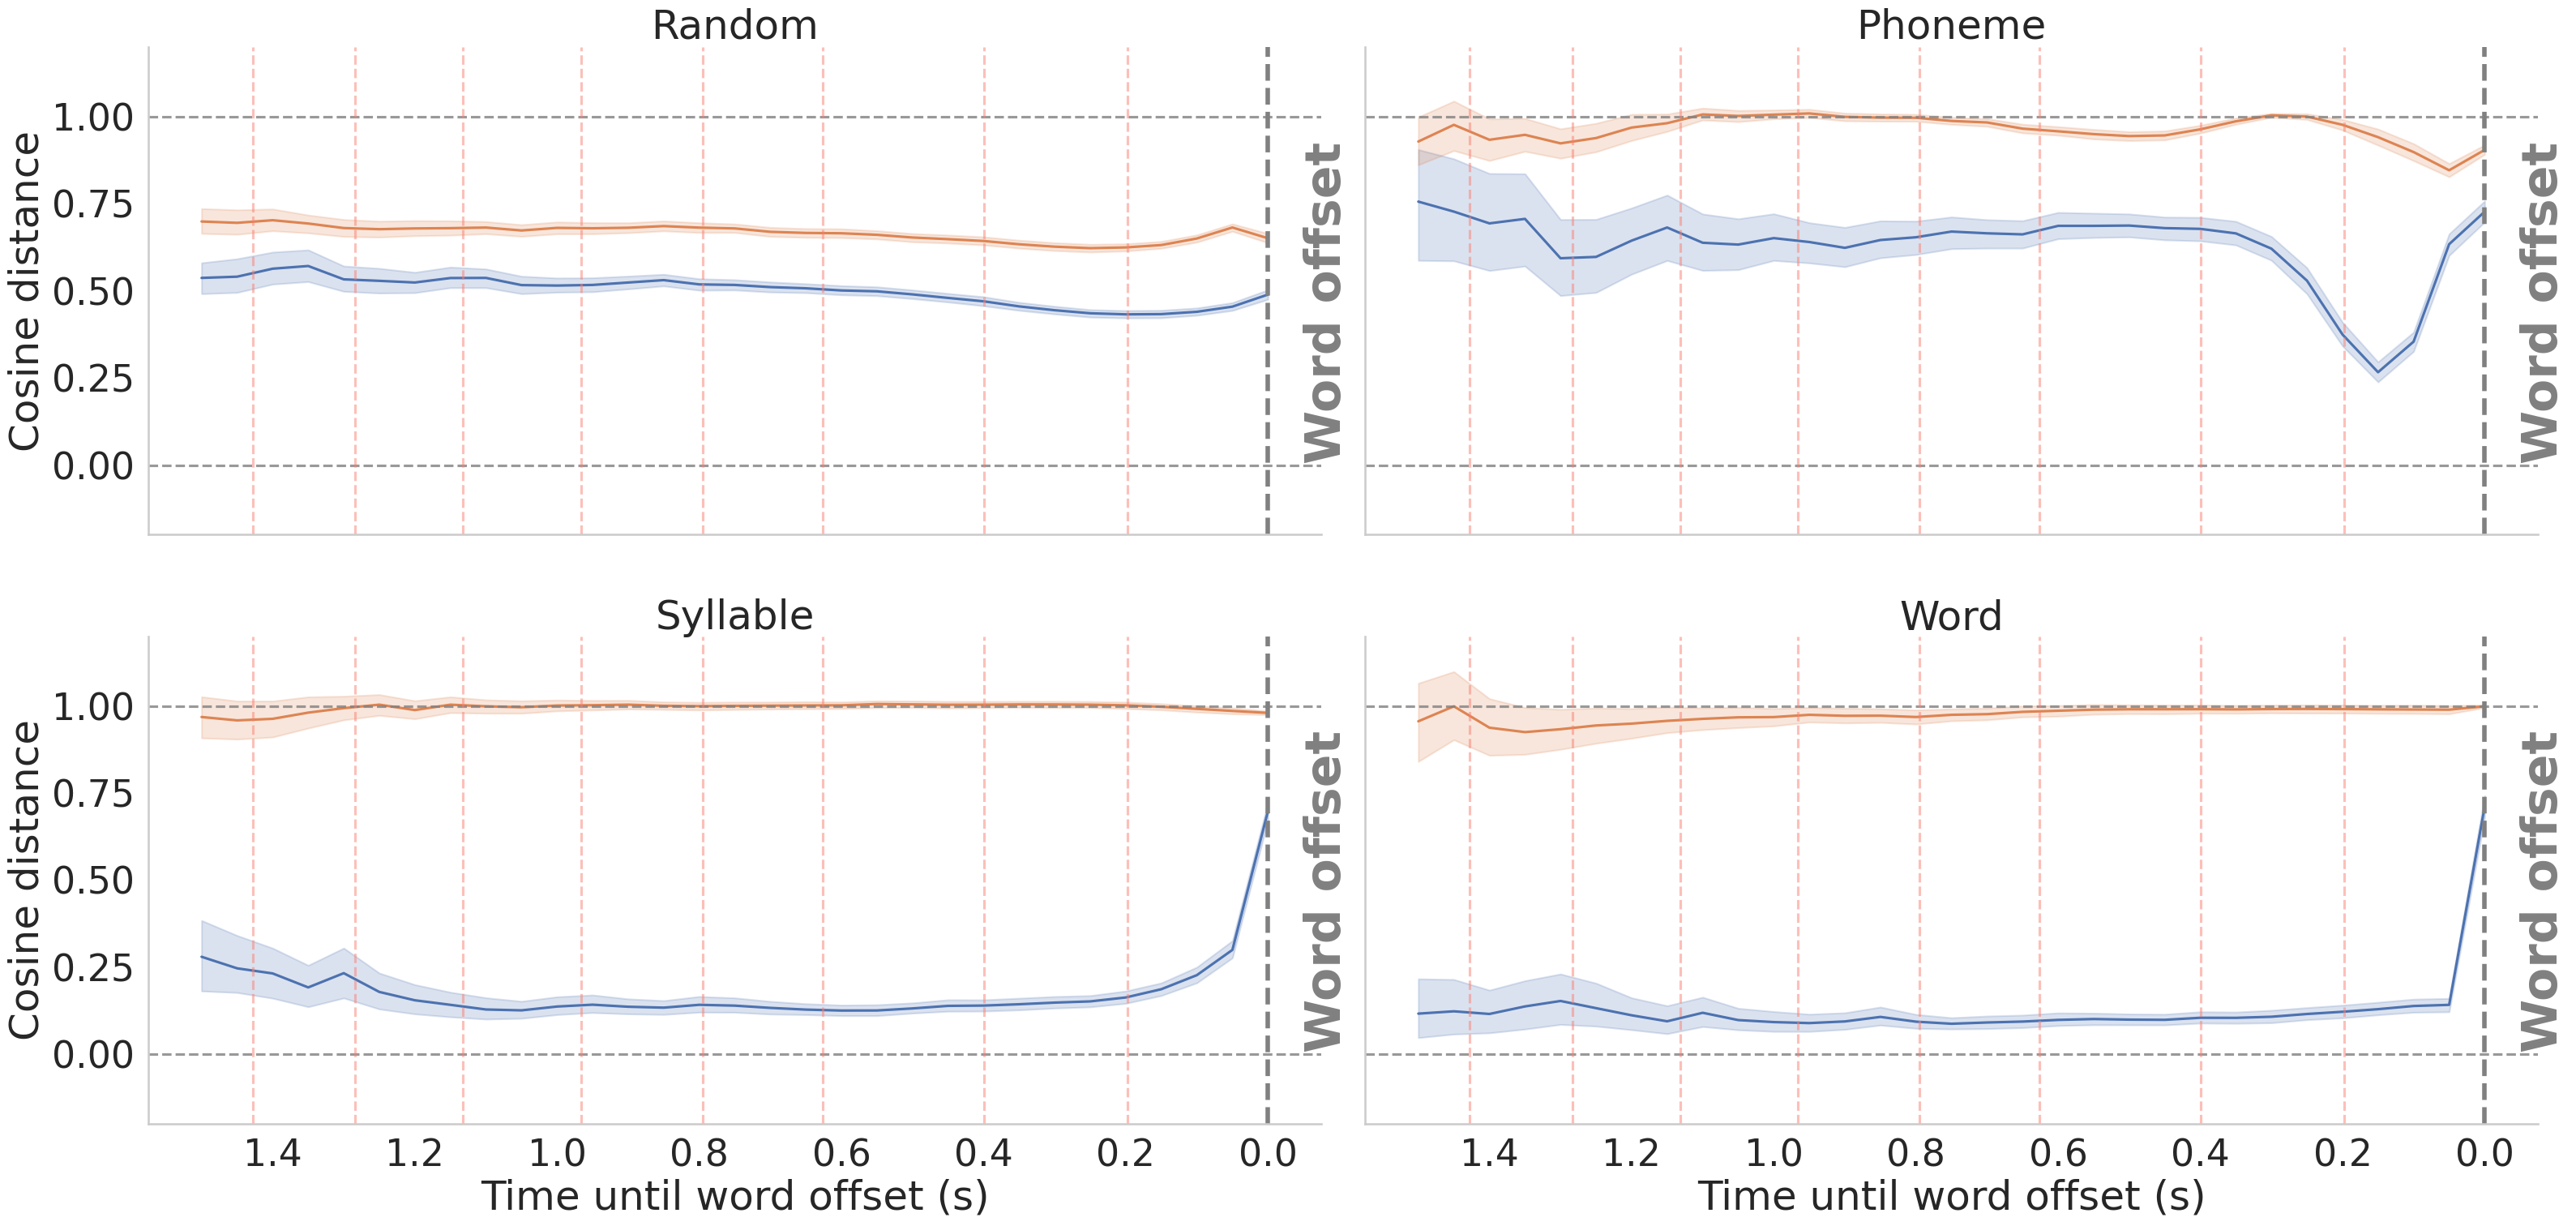

In [75]:
plot_coherence(word_distance_align_offset_df, "word", alignment="offset",
               plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by onset

In [28]:
word_onset_distance_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset.csv", plot_models, plot_equivalences)
word_onset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset_aligned_offset.csv", plot_models, plot_equivalences)

In [29]:
# DEV
word_onset_distance_df["time"] = word_onset_distance_df["frame"] / 20

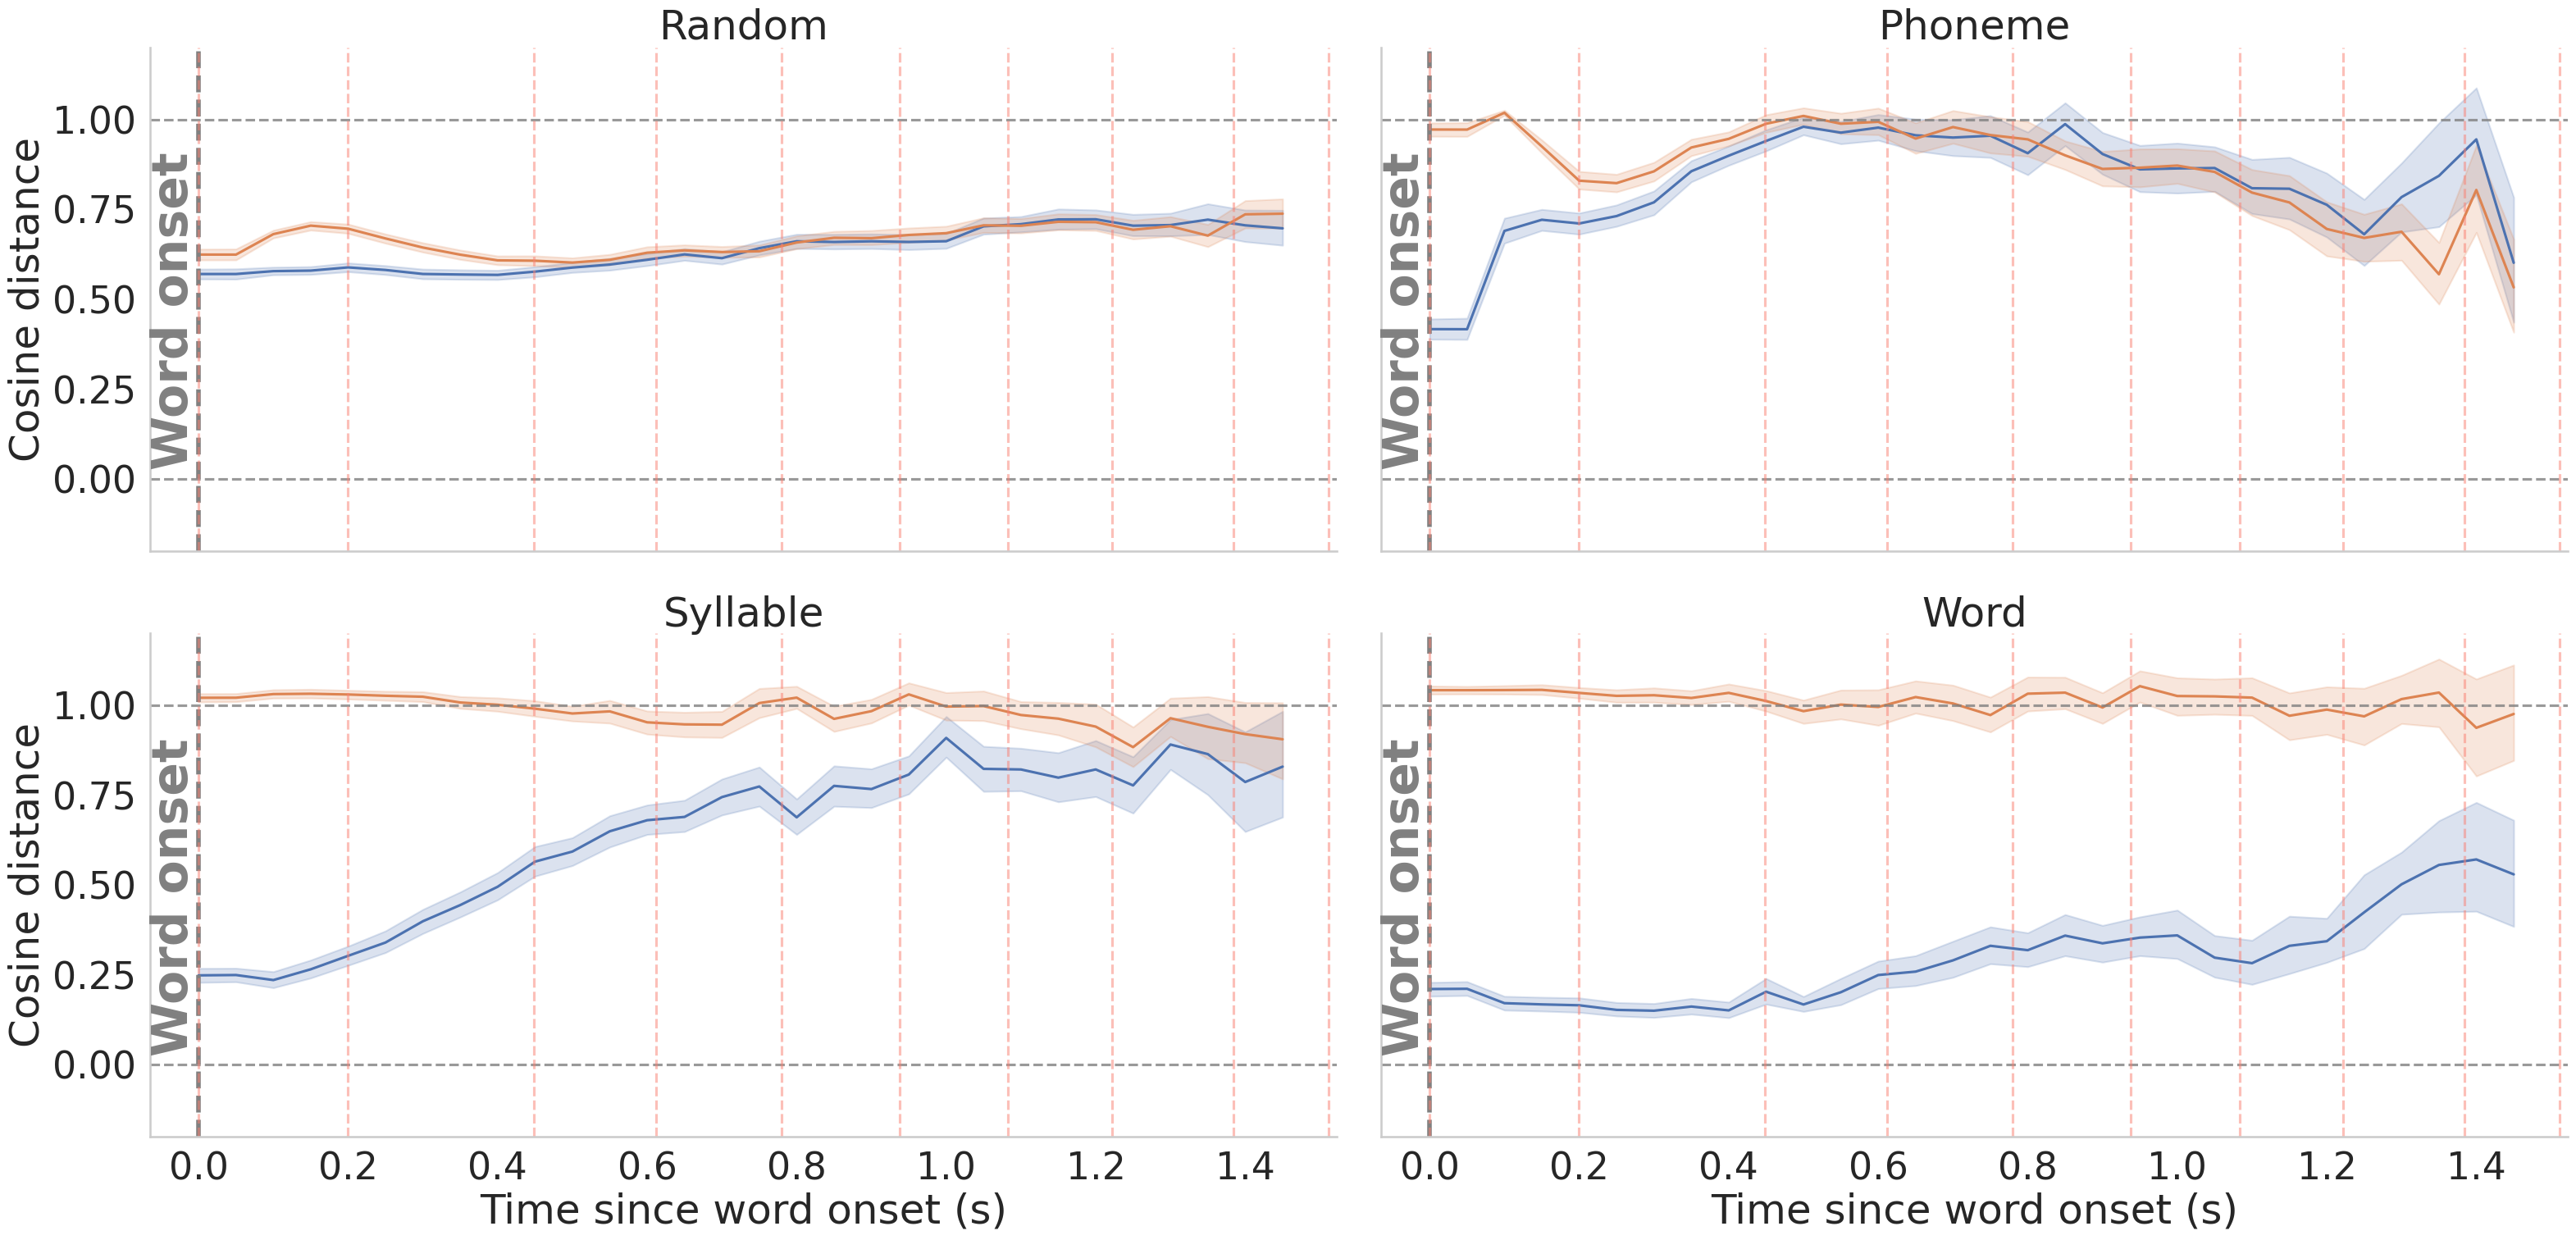

In [65]:
plot_coherence(word_onset_distance_df, "word", plot_phonemes=phoneme_in_word_mean_onsets)

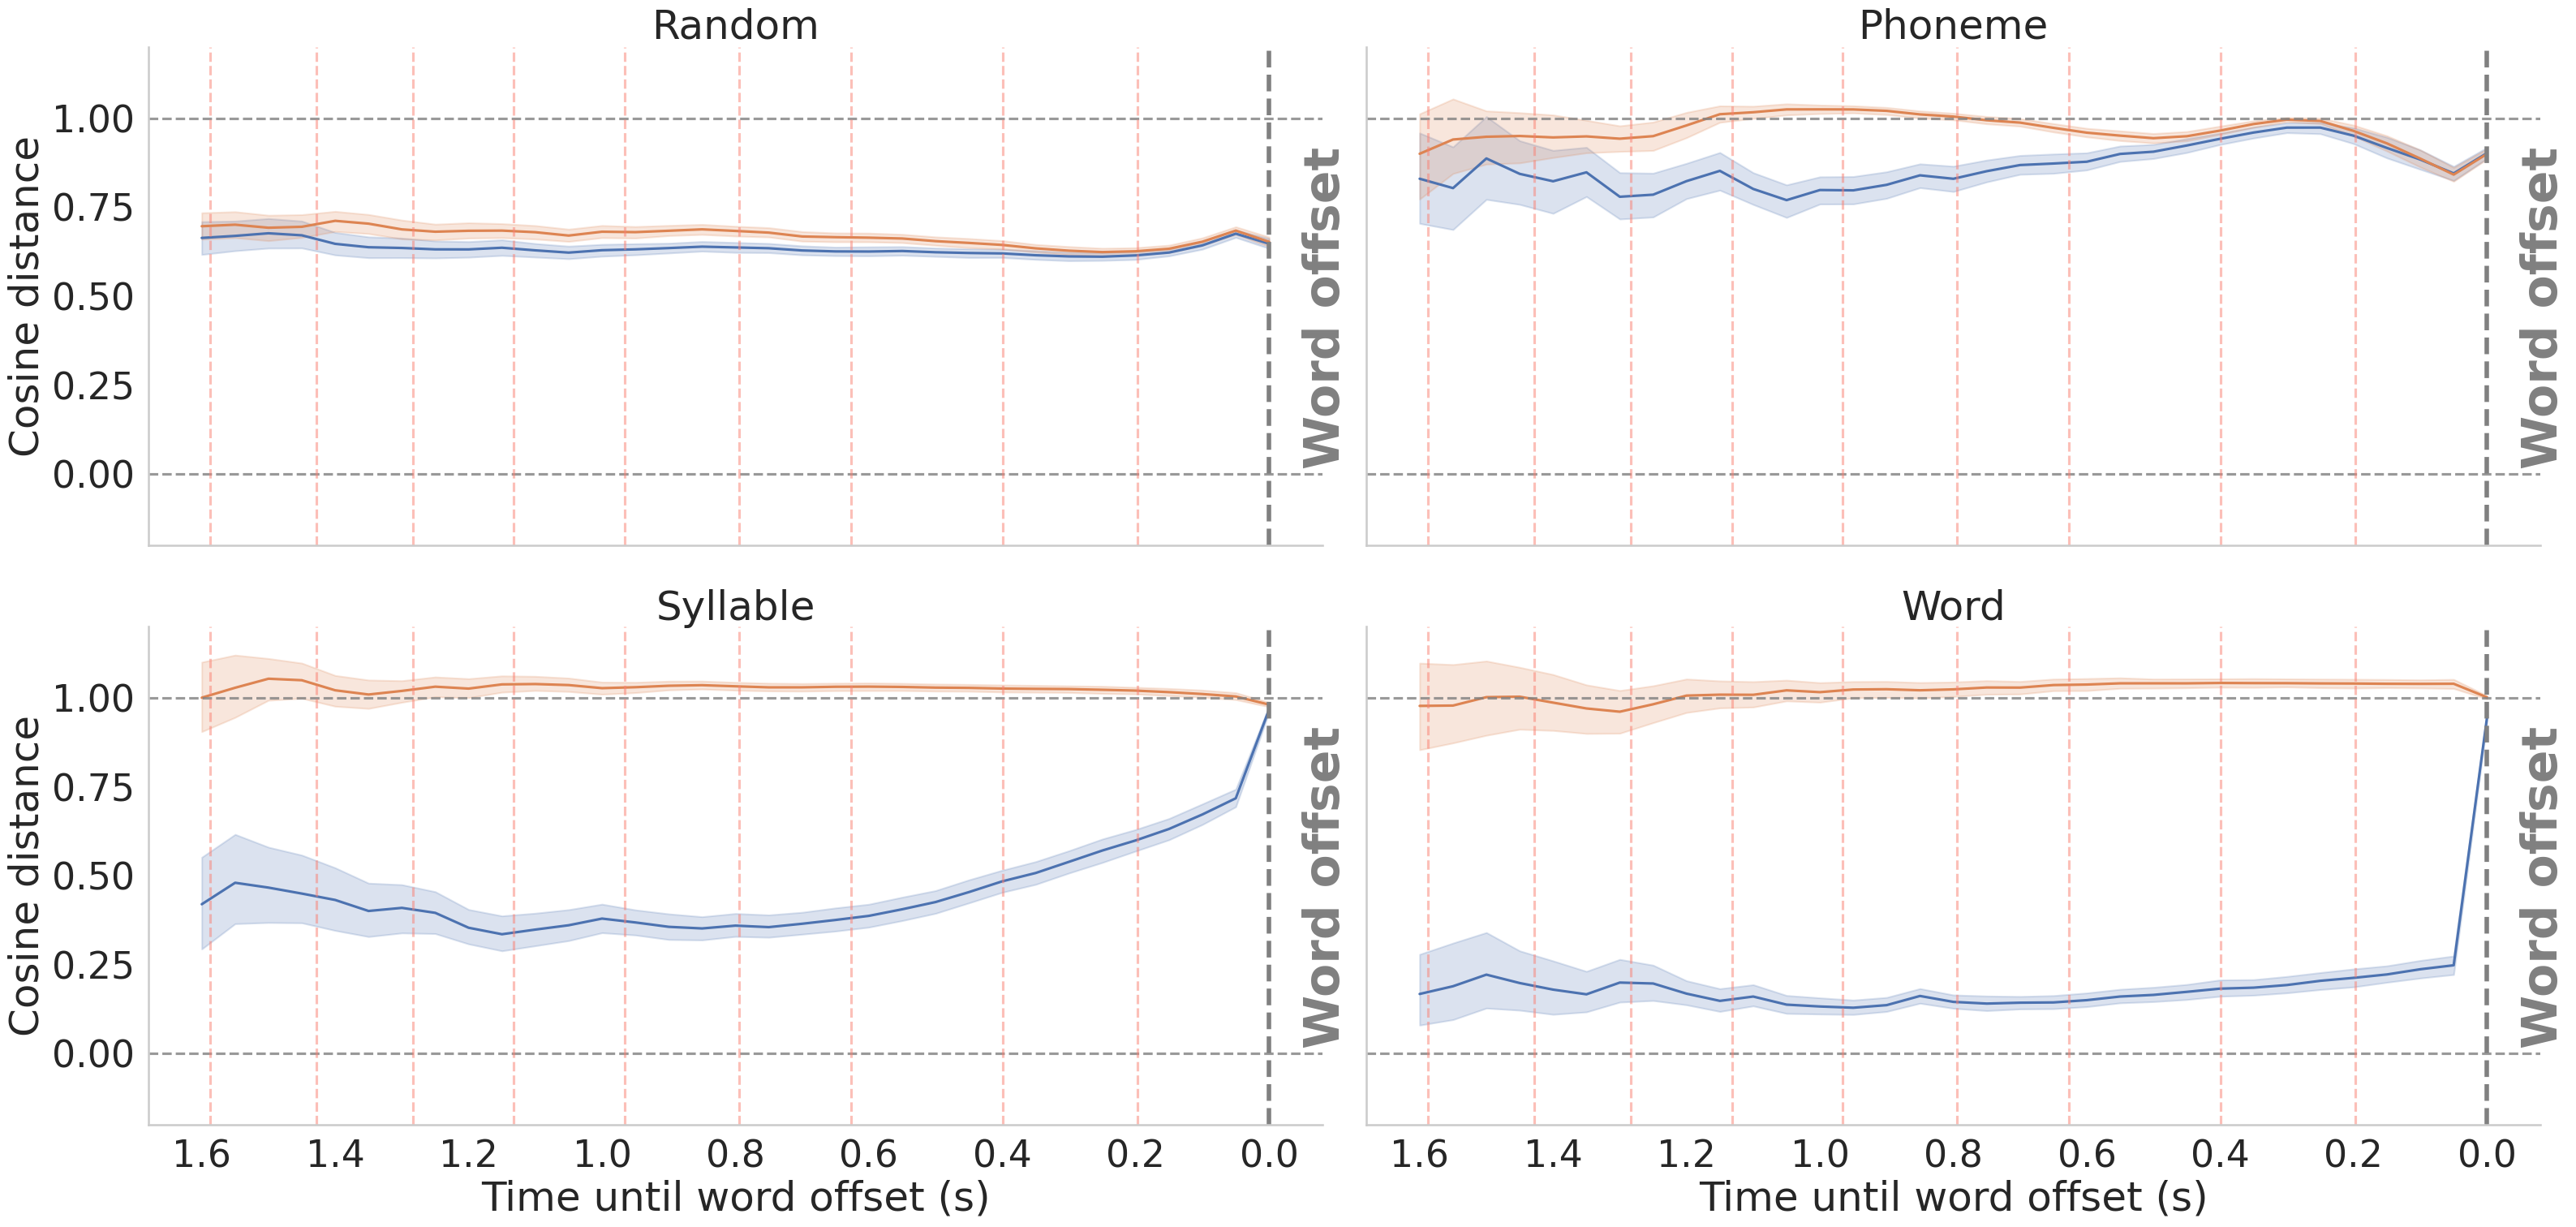

In [66]:
plot_coherence(word_onset_distance_align_offset_df, "word", alignment="offset", plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by offset

In [32]:
word_offset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_offset_aligned_offset.csv", plot_models, plot_equivalences)

In [33]:
# DEV
word_offset_distance_align_offset_df["time"] = (word_offset_distance_align_offset_df["frame"] - 1) / 20

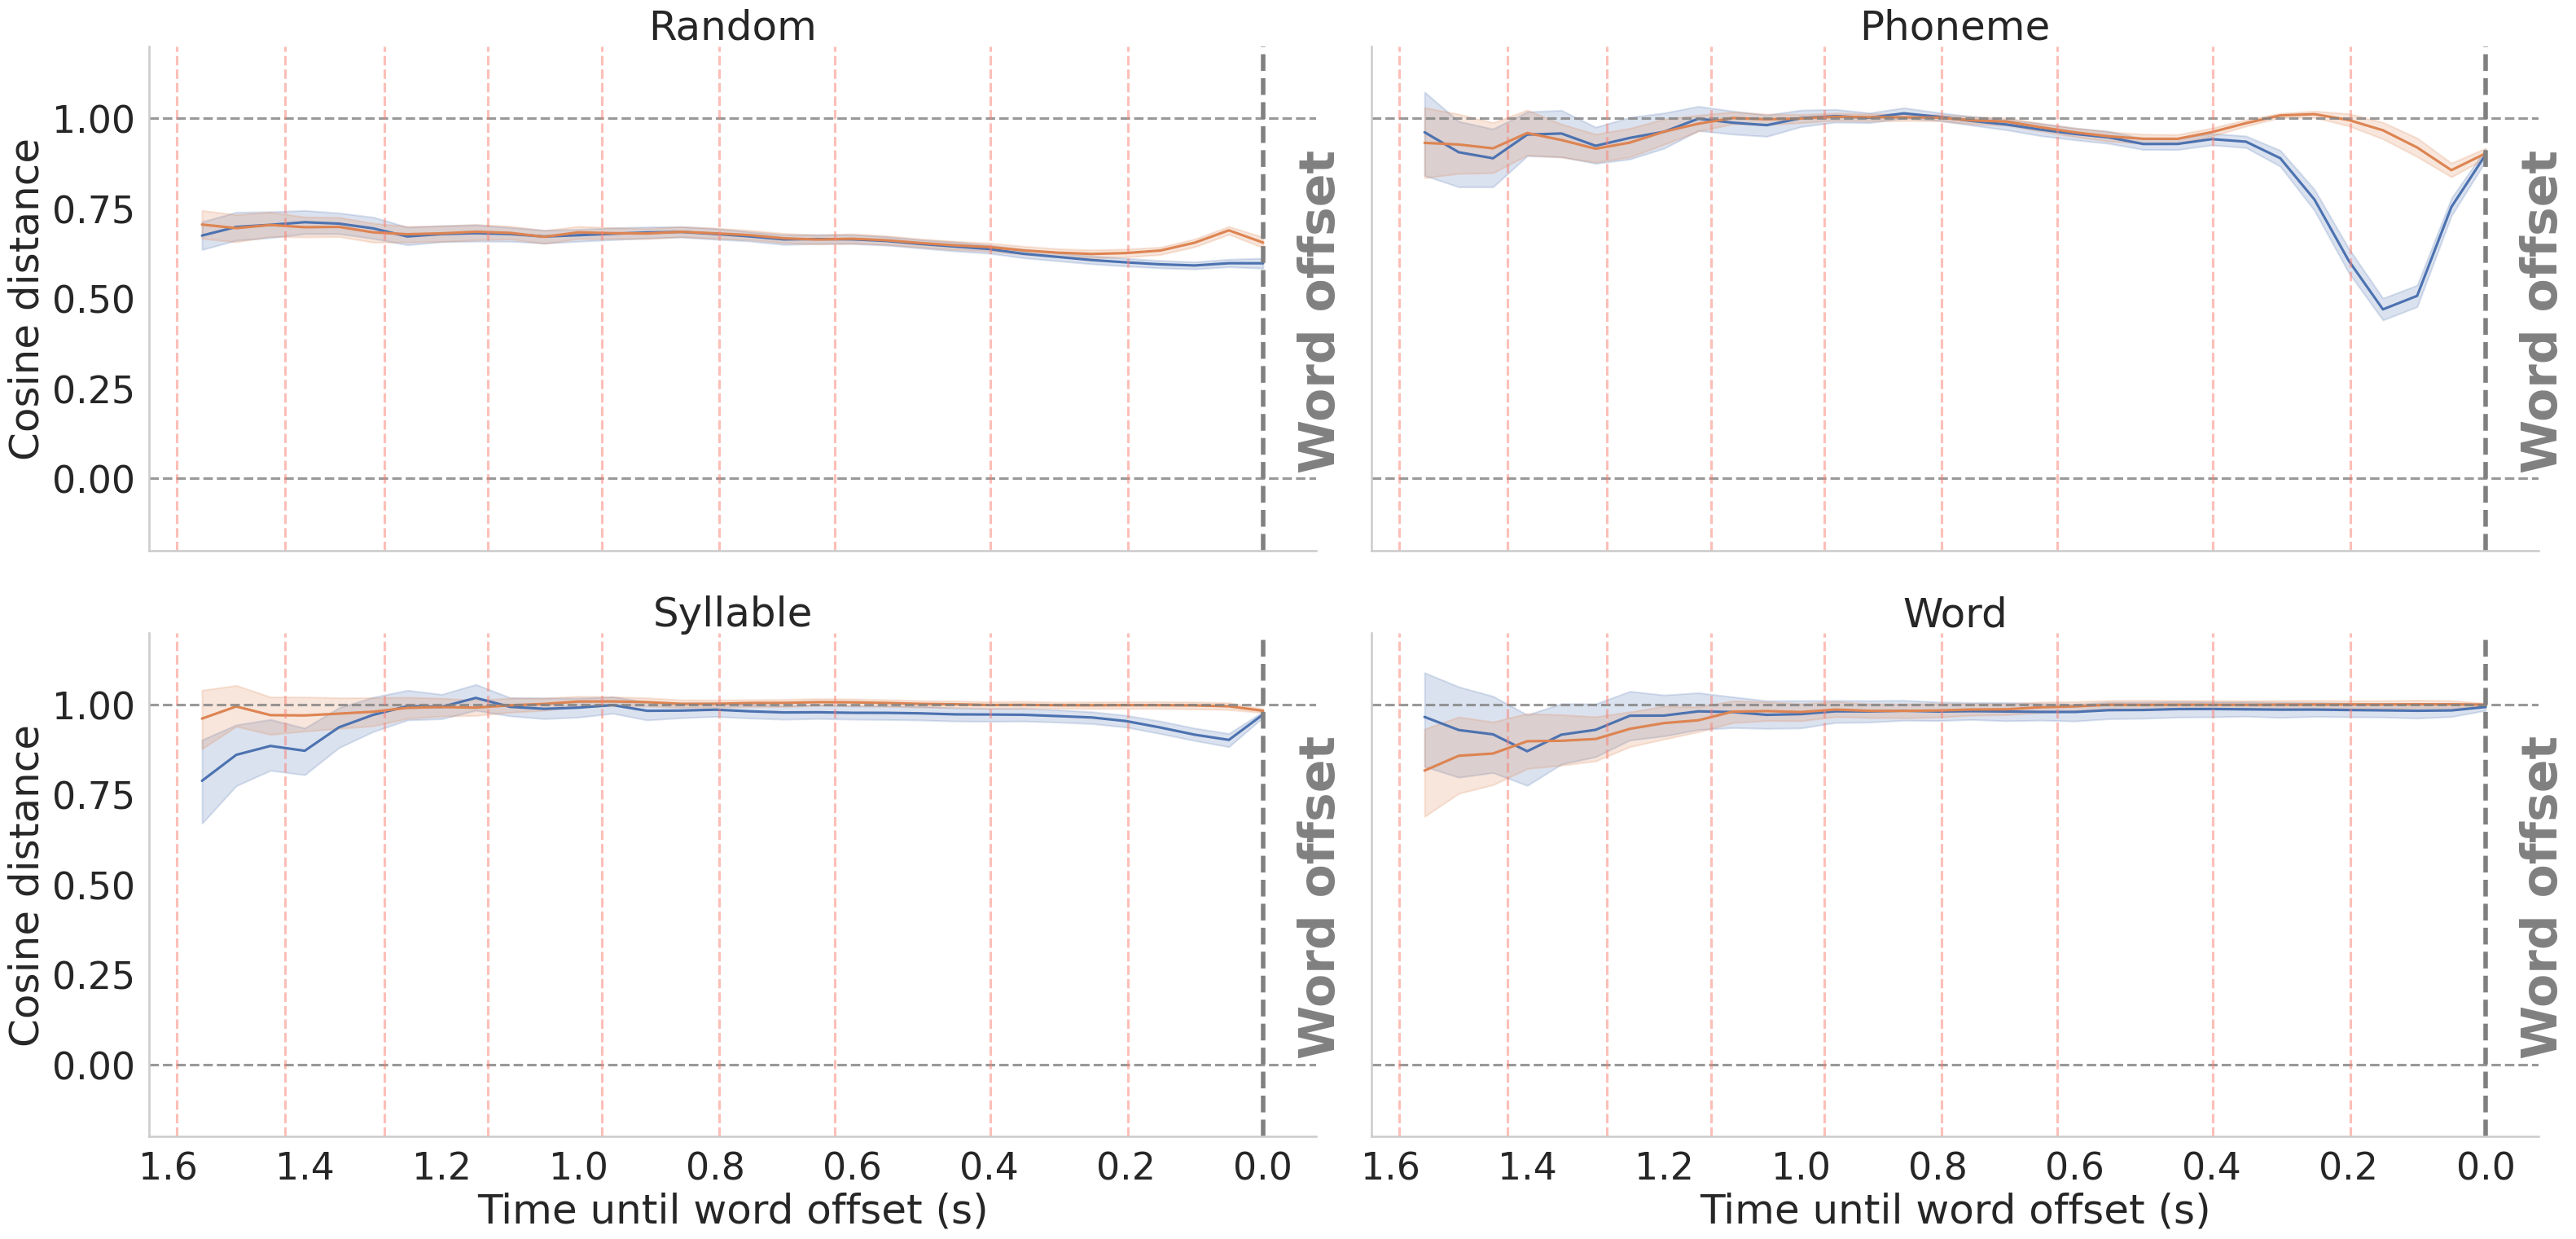

In [67]:
g = plot_coherence(word_offset_distance_align_offset_df, "word", alignment="offset",
                   plot_phonemes=phoneme_in_word_reverse_mean_onsets)

# adjust bottom of figure
g.fig.subplots_adjust(bottom=0.1)

# RSA analysis

## Phoneme level

In [110]:
phoneme_grouped_distances = pd.read_csv("outputs/notebooks/w2v2_6_8/phoneme/phoneme_coherence/grouped_distances.csv")

In [118]:
phoneme_rdm = phoneme_grouped_distances.pivot_table(index="p1", columns="p2", values="distance", aggfunc="mean")
phoneme_rdm.head()

p2  AA        AE        AH        AO        AW        AY         B        CH  \
p1                                                                             
AA NaN  0.029851  0.060965  0.023111  0.020469  0.026969  0.126169  0.420427   
AE NaN       NaN  0.060130  0.041953  0.092077  0.141809  0.127294  0.540925   
AH NaN       NaN       NaN  0.062576  0.061246  0.064151  0.112375  0.223343   
AO NaN       NaN       NaN       NaN  0.028775  0.050656  0.131102  0.652508   
AW NaN       NaN       NaN       NaN       NaN  0.144542  0.127881  0.636411   

p2         D        DH  ...        SH         T        TH        UH        UW  \
p1                      ...                                                     
AA  0.121571  0.042926  ...  0.296161  0.137032  0.310856  0.055164  0.031689   
AE  0.121786  0.041113  ...  0.406864  0.136974  0.310577  0.054206  0.036849   
AH  0.107371  0.046392  ...  0.225957  0.121279  0.220686  0.075079  0.065758   
AO  0.127114  0.041627  ...  0.422797  0.143191  0.321451  0.043990  0.031566   
AW  0.122359  0.041374  ...  0.411920  0.137674  0.313370  0.051958  0.045076   

p2         V         W         Y         Z        ZH  
p1                                                    
AA  0.240308  0.013234  0.018957  0.384021  0.269121  
AE  0.241924  0.013451  0.017079  0.405032  0.269506  
AH  0.201259  0.027268  0.032448  0.225613  0.222584  
AO  0.248015  0.007782  0.012721  0.725815  0.278440  
AW  0.243359  0.012781  0.016711  0.563495  0.271746  

[5 rows x 39 columns]

In [137]:
for p1 in phoneme_rdm.index:
    for p2 in phoneme_rdm.columns:
        if np.isnan(phoneme_rdm.loc[p1, p2]):
            phoneme_rdm.loc[p1, p2] = phoneme_rdm.loc[p2, p1]

# Set diagonal to 0
np.fill_diagonal(phoneme_rdm.values, 0)

<Axes: xlabel='p2', ylabel='p1'>

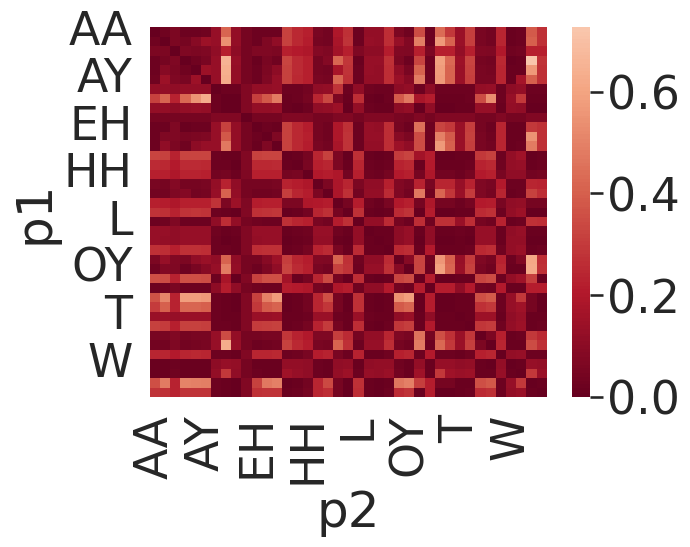

In [138]:
sns.heatmap(phoneme_rdm, center=1, cmap="RdBu")

Text(1441.9166666666665, 0.5, '')

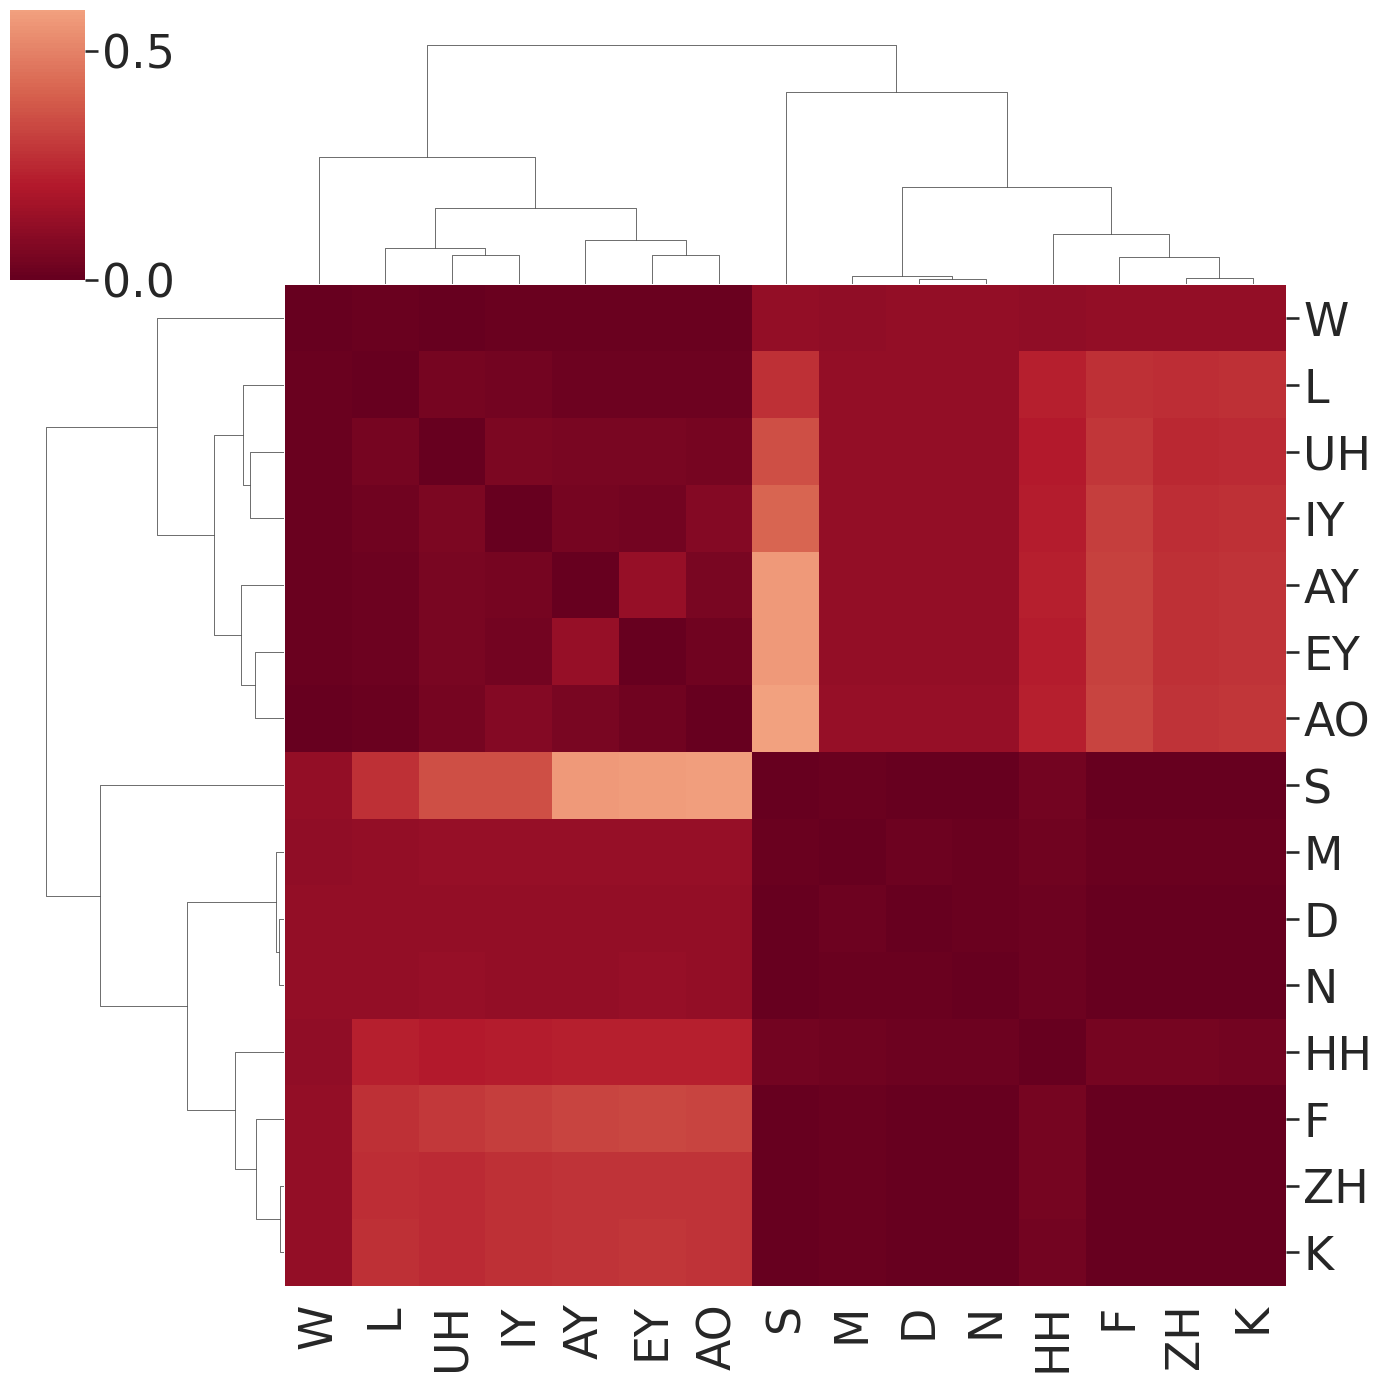

In [146]:
# f, ax = plt.subplots(figsize=(18, 18))
subsample_phonemes = np.random.choice(len(phoneme_rdm), 15, replace=False)
phoneme_rdm_subsample = phoneme_rdm.iloc[subsample_phonemes, subsample_phonemes]
g = sns.clustermap(phoneme_rdm_subsample, center=1, cmap="RdBu", figsize=(15, 15), colors_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)

Text(2804.4166666666665, 0.5, '')

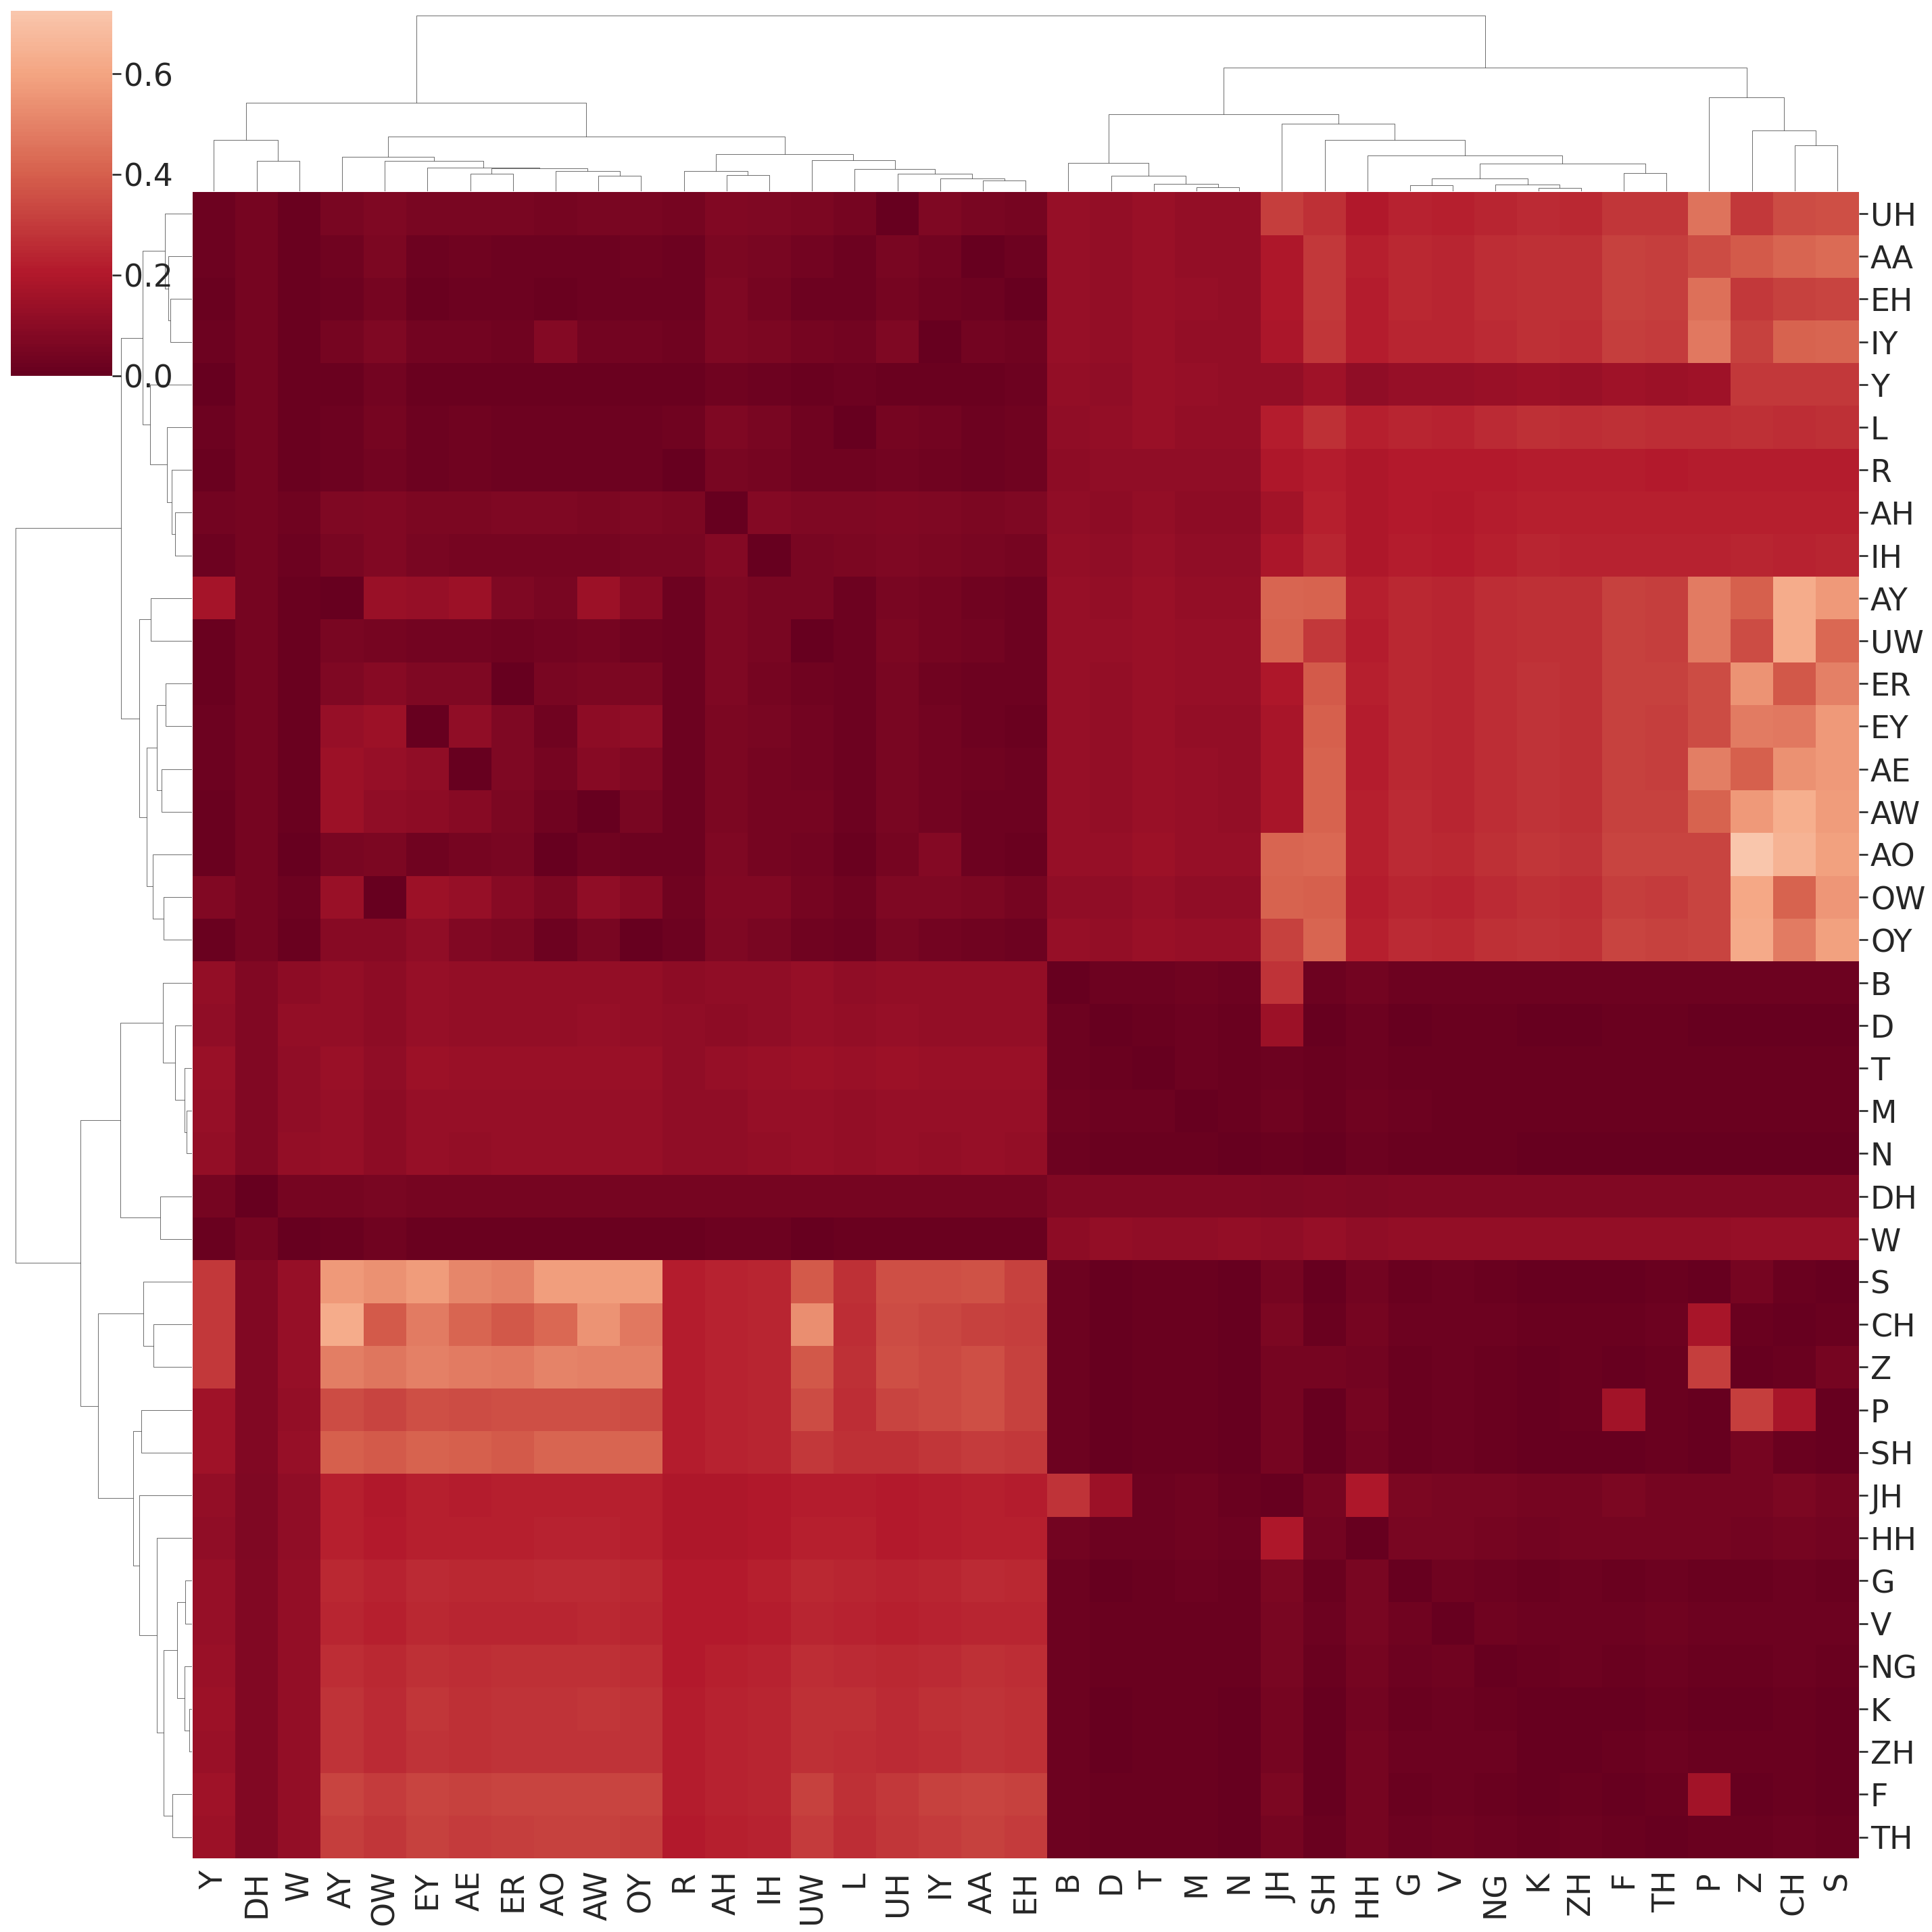

In [147]:
# f, ax = plt.subplots(figsize=(18, 18))
g = sns.clustermap(phoneme_rdm, center=1, cmap="RdBu", figsize=(30, 30), colors_ratio=0.1, dendrogram_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)